In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms

/home/vamsi/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("osunlp/MagicBrush")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 8807
    })
    dev: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 528
    })
})

In [4]:
print(ds['train'][0].keys())

dict_keys(['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'])


In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
])

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [7]:
import io
class MagicBrushDataset(Dataset):
    def __init__(self, split='train', fraction=1.0):
        if fraction<1.0:
            split = f"{split}[:{int(fraction * 100)}%]"
        self.dataset = load_dataset("osunlp/MagicBrush", split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the item from the dataset
        item = self.dataset[idx]

        # Process text: encode with BERT tokenizer and get embeddings
        text = item['instruction']
        tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        with torch.no_grad():
            text_embedding = bert_model(**tokens).last_hidden_state[:, 0, :]  # CLS token embedding (768-dimensional)

        if isinstance(item['source_img'], Image.Image):  # Already a PIL image
            image = item['source_img'].convert('RGB')
        else:
            raise ValueError(f"Unexpected type for 'source_img': {type(item['source_img'])}")
        
        # Apply image transformations
        image = image_transform(image)

        # Process binary mask (convert to binary tensor)
        if isinstance(item['mask_img'], Image.Image):  # Check if already a PIL image
            mask = item['mask_img'].convert('L')
        else:
            raise ValueError(f"Unexpected type for 'mask': {type(item['mask'])}")

        mask = transforms.Resize((224, 224))(mask)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()  # Binary mask
        mask = mask.squeeze(0)
        return text_embedding.squeeze(0), image, mask

In [8]:
train_dataset = MagicBrushDataset(split='train', fraction=0.5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=False)

In [9]:
test_dataset = MagicBrushDataset(split='dev')
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=False)

In [10]:
print(len(train_dataset), len(test_dataset))

4404 528


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [12]:
# reference : https://www.restack.io/p/cross-attention-answer-sequence-to-sequence-cat-ai

In [13]:
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.heads = heads
        self.embed_size = embed_size
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x, context):
        N = x.shape[0]  # Number of samples
        value_len, key_len, query_len = context.shape[1], context.shape[1], x.shape[1]
        
        # Split embedding into multiple heads
        values = self.values(context).view(N, value_len, self.heads, self.embed_size // self.heads)
        keys = self.keys(context).view(N, key_len, self.heads, self.embed_size // self.heads)
        queries = self.queries(x).view(N, query_len, self.heads, self.embed_size // self.heads)
                
        # Calculate attention scores
        energy = torch.einsum('nqhd,nkhd->nqhk', [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # Weighted sum of values
        out = torch.einsum('nqhk,nvhd->nqhd', [attention, values]).reshape(N, query_len, self.embed_size)
        return self.fc_out(out)

In [14]:

from torchvision.models import ResNet50_Weights

resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False

resnet = nn.Sequential(*list(resnet.children())[:-1])

projection_layer = nn.Linear(2048, 768)

class MaskPredictor(nn.Module):
    def __init__(self, resnet, projection_layer, embed_size=768, heads=8):
        super(MaskPredictor, self).__init__()
        self.resnet = resnet
        self.projection = projection_layer
        self.cross_attention = CrossAttention(embed_size, heads)  # Integrating Cross Attention
        
        # Mask prediction network
        self.mask_prediction_network =  nn.Sequential(
            # Step 1: Expand the channel dimension
            nn.ConvTranspose2d(768, 512, kernel_size=3, stride=2, padding=0),  # [32, 512, 3, 3]
            nn.ReLU(inplace=True),
            
            # Step 2: Further upsample with larger spatial dimensions
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1),  # [32, 256, 7, 7]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2),  # [32, 128, 14, 14]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1),   # [32, 64, 28, 28]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1),    # [32, 32, 56, 56]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=0),    # [32, 16, 112, 112]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=2),     # [32, 1, 224, 224]
            nn.Sigmoid()  # Assuming output needs to be normalized to [0, 1]
        )

        

    def forward(self, img, text):
        # Image feature extraction using ResNet
        features = self.resnet(img)
        features = features.view(features.size(0), -1)  # Flatten features
        img_features = self.projection(features)  # Project to the desired feature space
        

        # Cross-Attention: Text as query, Image features as key and value
        attention_out = self.cross_attention(text.unsqueeze(1), img_features.unsqueeze(1))  # (batch_size, seq_len, embed_size)
        

        # Prepare the output from attention mechanism
        attention_out = attention_out.view(attention_out.size(0), attention_out.size(2), 1, 1)# Add a dimension for the mask prediction network
        

        # Pass through the mask prediction network
        out = self.mask_prediction_network(attention_out)  # Shape: [batch_size, 1, 224, 224]
        
        return out.squeeze(1)  # Final output shape: [batch_size, 224, 224]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskPredictor(resnet, projection_layer).to(device)
print(device)

cuda


In [ ]:
import torch
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = torch.load("crossattention_maskpredictor 200.pth")


# Assuming 'model' is defined elsewhere, move it to the device (GPU)
model = model.to(device)

criterion = nn.BCELoss()  # Combine sigmoid and BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        print("gtmask",gt_mask.type,gt_mask)
        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 224, 224]

        # Compute loss
        
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, "crossattention_maskpredictor.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


/tmp/ipykernel_816964/2554060247.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("crossattention_maskpredictor 100.pth")


FileNotFoundError: [Errno 2] No such file or directory: 'crossattention_maskpredictor 100.pth'

In [16]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("crossattention_maskpredictor_200.pth")
model.eval()  # Set model to evaluation mode

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples

    

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")

        

/tmp/ipykernel_81546/3825719415.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("crossattention_maskpredictor_200.pth")
100%|██████████| 138/138 [04:3

Average IoU: 0.9617


In [17]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("crossattention_maskpredictor_100.pth")
model.eval()  # Set model to evaluation mode

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples

    

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")

        

/tmp/ipykernel_104725/201358896.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("crossattention_maskpredictor_100.pth")
100%|██████████| 138/138 [04:5

Average IoU: 0.9166


In [18]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("crossattention_maskpredictor_200.pth")
model.eval()

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop
with torch.no_grad():
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)
        img = img.to(device)
        gt_mask = gt_mask.to(device)

        # Invert ground truth mask to match black-foreground convention
        gt_mask_inverted = 1 - gt_mask  # Black becomes foreground (0 -> 1, 1 -> 0)

        # Predict masks
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.8).float()  # Threshold predictions
        pred_mask_inverted = 1 - pred_mask  # Invert predicted mask

        # Compute IoU
        intersection = (pred_mask_inverted * gt_mask_inverted).sum(dim=(1, 2))  # Element-wise AND
        union = (pred_mask_inverted + gt_mask_inverted).clamp(0, 1).sum(dim=(1, 2))  # Element-wise OR
        iou = intersection / (union + 1e-6)  # Avoid division by zero

        iou_sum += iou.sum().item()  # Accumulate IoU for the batch
        total_samples += iou.size(0)  # Increment total sample count

        # Move data to CPU for optional visualization
        img = img.cpu()
        gt_mask = gt_mask.cpu()
        pred_mask = pred_mask.cpu()

# Calculate and print the average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")


/tmp/ipykernel_104725/597651673.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("crossattention_maskpredictor_200.pth")
  6%|▌         | 8/138 [00:18<

KeyboardInterrupt: 

/tmp/ipykernel_104725/1920447343.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("crossattention_maskpredictor_200.pth")
  0%|          | 0/138 [00:00

tensor(0.8196, device='cuda:0')


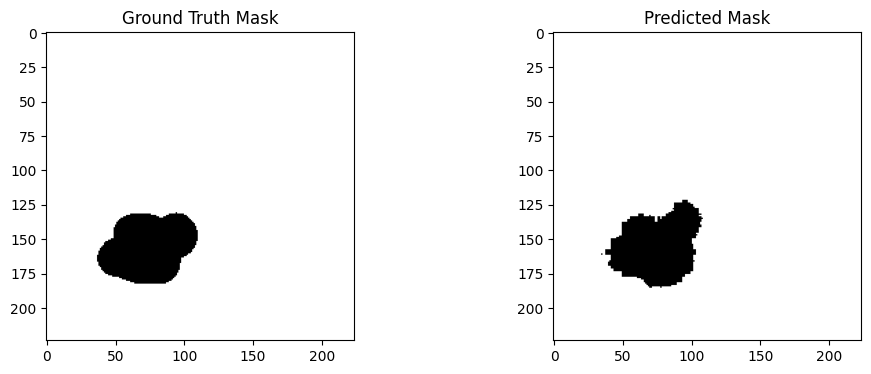

  1%|          | 1/138 [00:26<59:23, 26.01s/it]

tensor(0.7470, device='cuda:0')


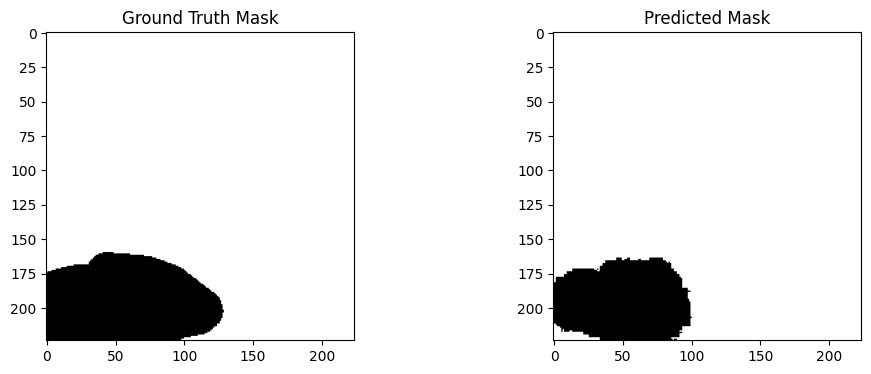

  1%|▏         | 2/138 [00:26<24:54, 10.99s/it]

tensor(0.7826, device='cuda:0')


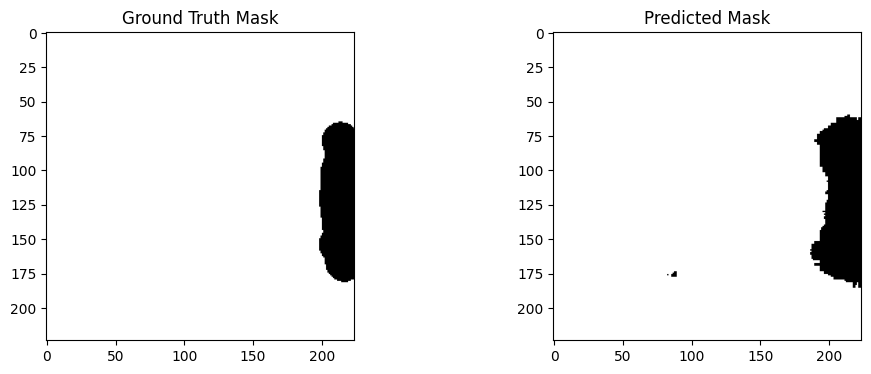

  2%|▏         | 3/138 [00:26<13:52,  6.16s/it]

tensor(0.8837, device='cuda:0')


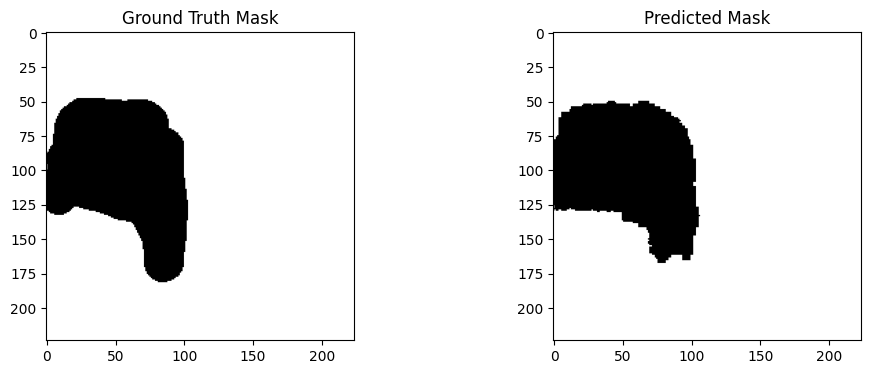

  3%|▎         | 4/138 [00:27<08:44,  3.91s/it]

tensor(0.9250, device='cuda:0')


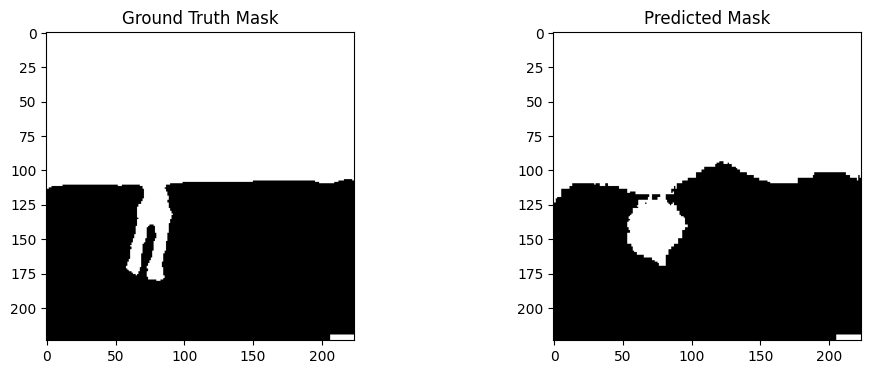

  4%|▎         | 5/138 [00:28<06:05,  2.75s/it]

tensor(0.1404, device='cuda:0')


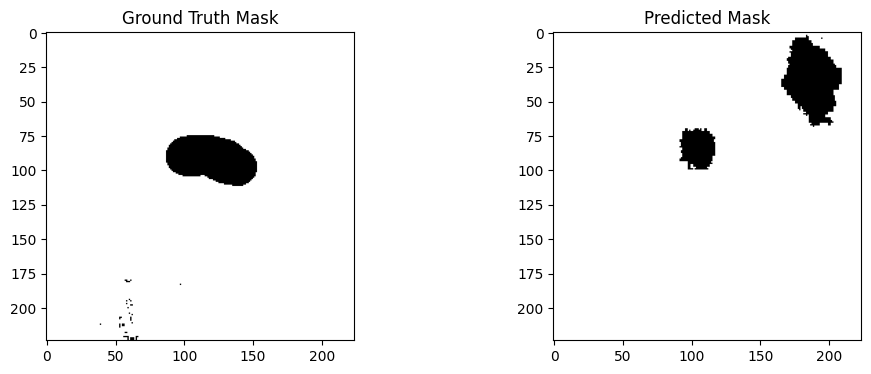

  4%|▍         | 6/138 [00:28<04:18,  1.96s/it]

tensor(0.9301, device='cuda:0')


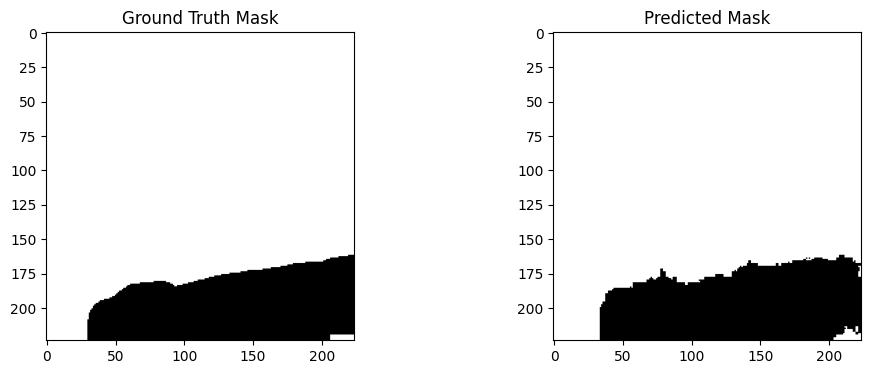

  5%|▌         | 7/138 [00:28<03:10,  1.45s/it]

tensor(0.6001, device='cuda:0')


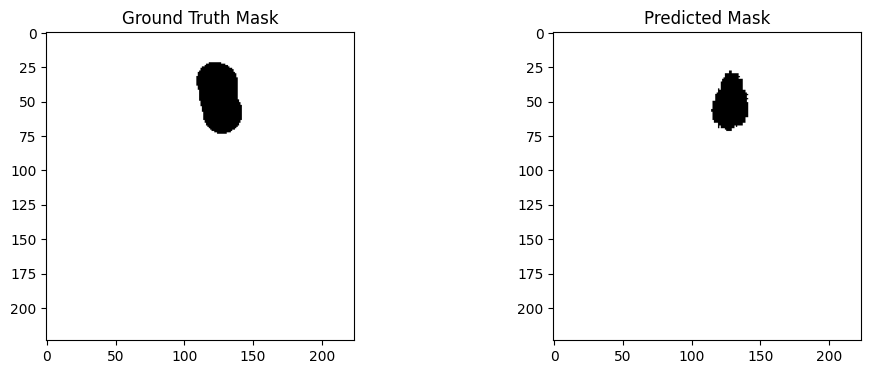

  6%|▌         | 8/138 [00:29<02:26,  1.13s/it]

tensor(0.4995, device='cuda:0')


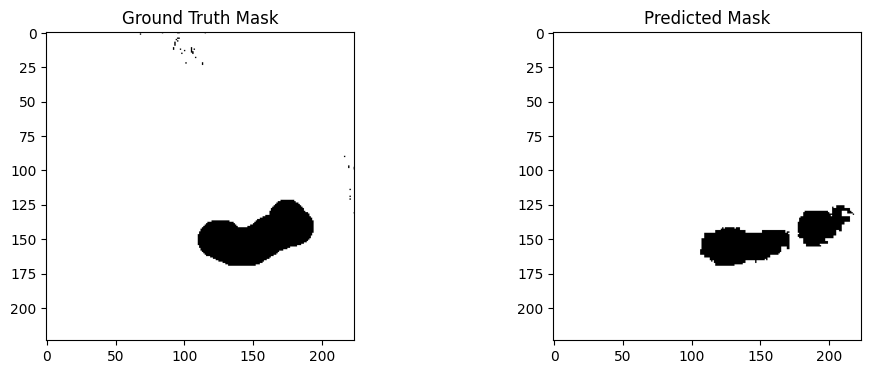

  7%|▋         | 9/138 [00:43<11:28,  5.33s/it]

tensor(0.9248, device='cuda:0')


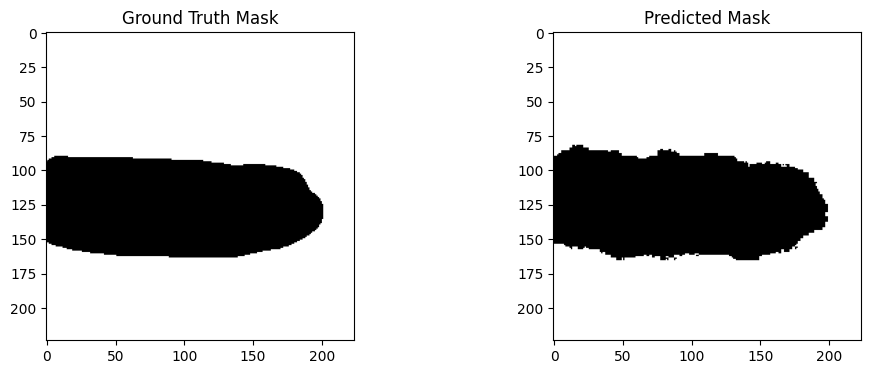

  7%|▋         | 10/138 [00:44<08:13,  3.86s/it]

tensor(0., device='cuda:0')


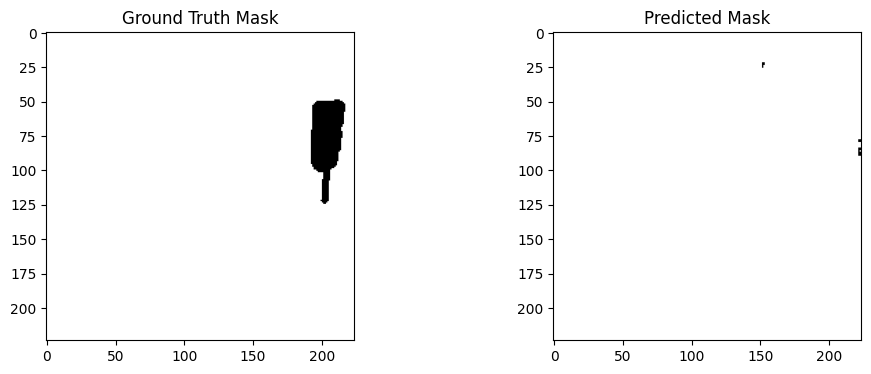

  8%|▊         | 11/138 [00:45<06:06,  2.89s/it]

tensor(0.9104, device='cuda:0')


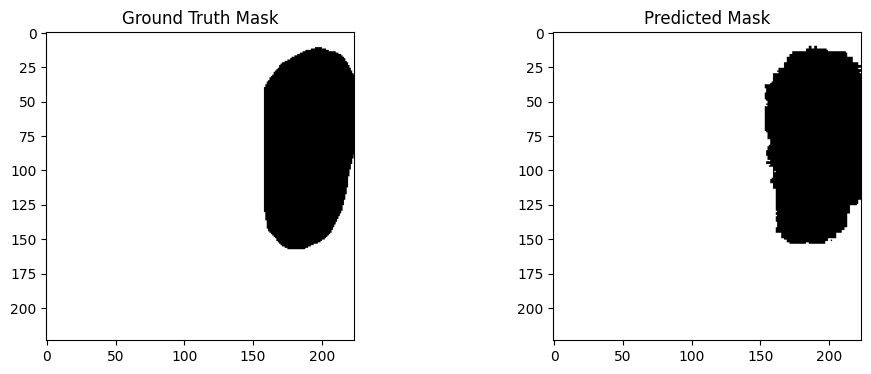

  9%|▊         | 12/138 [00:46<05:00,  2.39s/it]

tensor(0.9480, device='cuda:0')


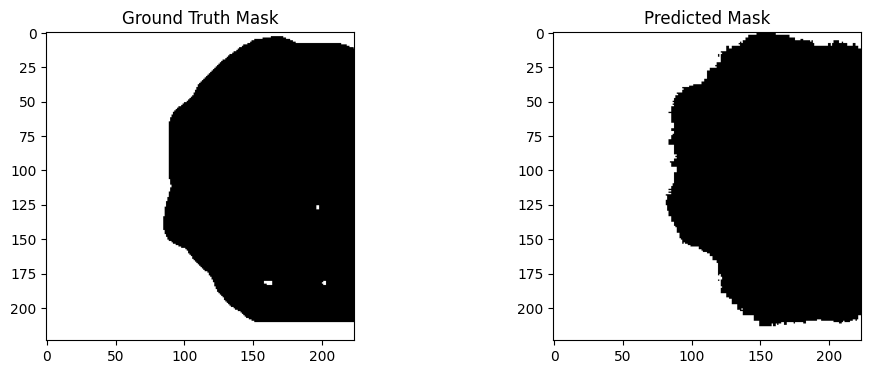

  9%|▉         | 13/138 [00:46<03:46,  1.81s/it]

tensor(0.0360, device='cuda:0')


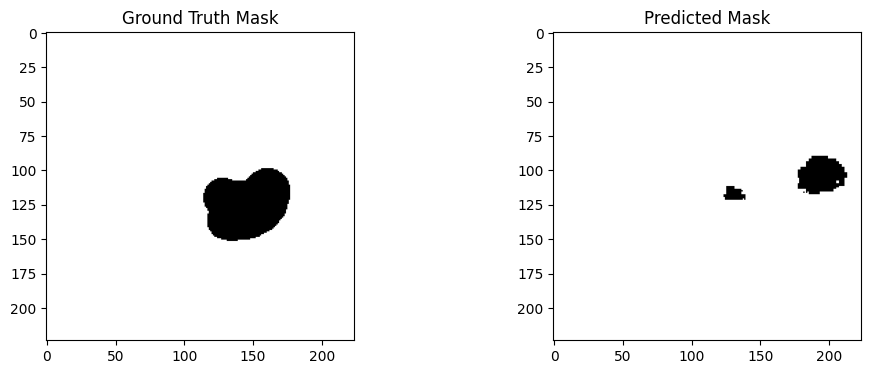

 10%|█         | 14/138 [00:47<02:55,  1.41s/it]

tensor(0.8406, device='cuda:0')


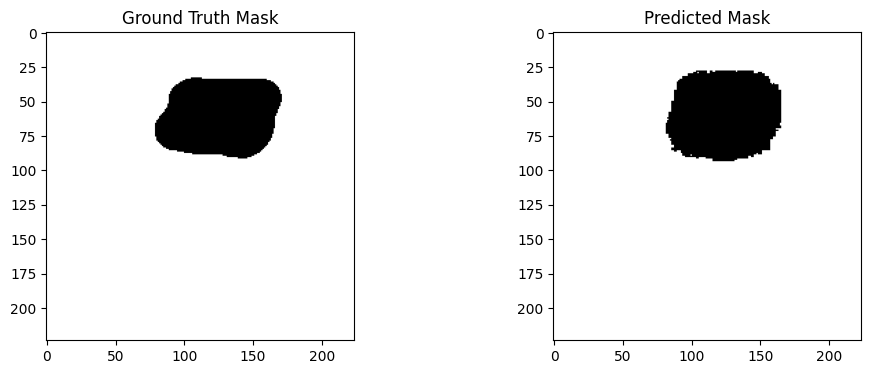

 11%|█         | 15/138 [00:47<02:20,  1.14s/it]

tensor(0.9133, device='cuda:0')


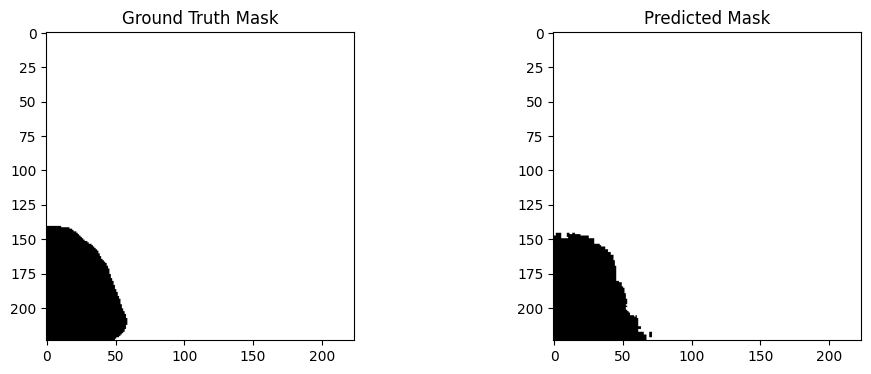

 12%|█▏        | 16/138 [00:48<02:03,  1.01s/it]

tensor(0., device='cuda:0')


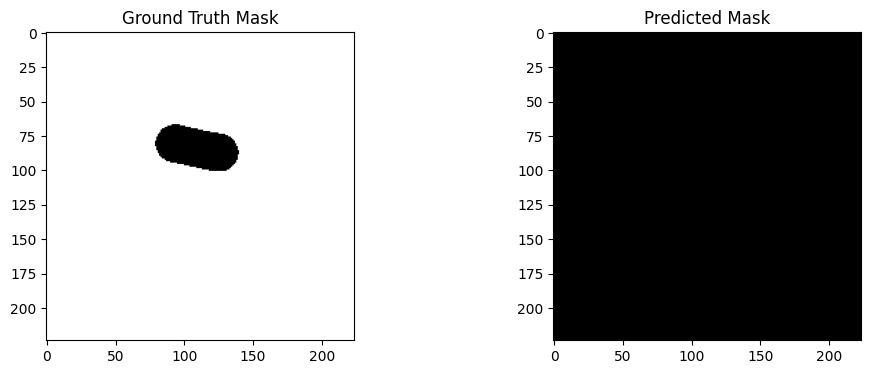

 12%|█▏        | 17/138 [01:02<09:55,  4.92s/it]

tensor(0.7610, device='cuda:0')


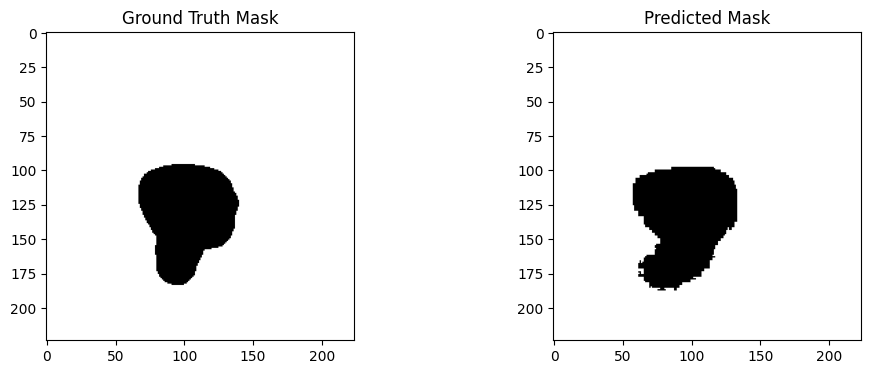

 13%|█▎        | 18/138 [01:02<07:07,  3.56s/it]

tensor(0., device='cuda:0')


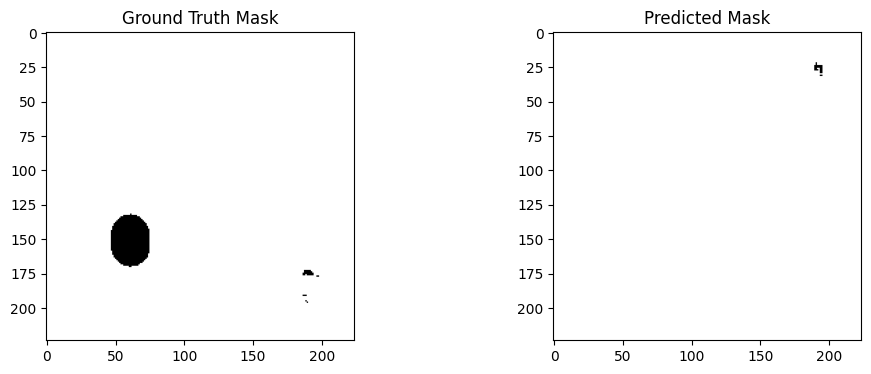

 14%|█▍        | 19/138 [01:03<05:12,  2.62s/it]

tensor(0.8573, device='cuda:0')


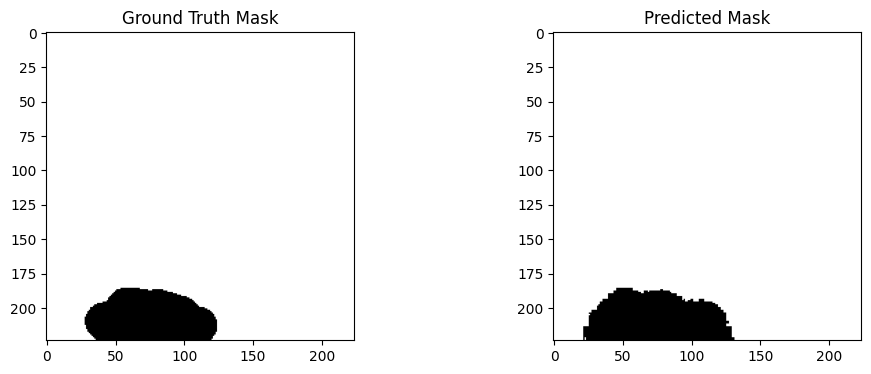

 16%|█▌        | 22/138 [01:03<02:05,  1.08s/it]

tensor(0.9577, device='cuda:0')
tensor(0.7751, device='cuda:0')
tensor(0.7005, device='cuda:0')


 17%|█▋        | 24/138 [01:04<01:18,  1.46it/s]

tensor(0.4563, device='cuda:0')


 20%|█▉        | 27/138 [01:21<04:55,  2.66s/it]

tensor(0.8604, device='cuda:0')
tensor(0.4161, device='cuda:0')
tensor(0., device='cuda:0')


 22%|██▏       | 30/138 [01:21<02:27,  1.36s/it]

tensor(0.3753, device='cuda:0')
tensor(0.8489, device='cuda:0')
tensor(0.2378, device='cuda:0')


 22%|██▏       | 31/138 [01:21<02:00,  1.13s/it]

tensor(0.8835, device='cuda:0')
tensor(0.7326, device='cuda:0')


 25%|██▍       | 34/138 [01:40<05:38,  3.26s/it]

tensor(0.5155, device='cuda:0')
tensor(0.8579, device='cuda:0')


 26%|██▌       | 36/138 [01:40<03:15,  1.92s/it]

tensor(0.8241, device='cuda:0')
tensor(0.8997, device='cuda:0')
tensor(0.6312, device='cuda:0')


 28%|██▊       | 39/138 [01:40<01:30,  1.09it/s]

tensor(0.8922, device='cuda:0')
tensor(0.8355, device='cuda:0')
tensor(0.6520, device='cuda:0')


 30%|███       | 42/138 [02:00<05:30,  3.44s/it]

tensor(0.9233, device='cuda:0')
tensor(0.7946, device='cuda:0')


 31%|███       | 43/138 [02:00<04:11,  2.65s/it]

tensor(0.2553, device='cuda:0')


 33%|███▎      | 46/138 [02:01<01:58,  1.29s/it]

tensor(0.2014, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8677, device='cuda:0')


 35%|███▍      | 48/138 [02:01<01:15,  1.20it/s]

tensor(0.6888, device='cuda:0')
tensor(0.8865, device='cuda:0')


 36%|███▌      | 50/138 [02:17<04:37,  3.15s/it]

tensor(0.7827, device='cuda:0')
tensor(0.6837, device='cuda:0')


 37%|███▋      | 51/138 [02:17<03:31,  2.44s/it]

tensor(0.8025, device='cuda:0')


 38%|███▊      | 53/138 [02:18<02:06,  1.49s/it]

tensor(0.9328, device='cuda:0')
tensor(0.9453, device='cuda:0')


 41%|████      | 56/138 [02:18<00:53,  1.54it/s]

tensor(0.6580, device='cuda:0')
tensor(0.8306, device='cuda:0')
tensor(0.9618, device='cuda:0')


 41%|████▏     | 57/138 [02:35<05:59,  4.44s/it]

tensor(0.9041, device='cuda:0')
tensor(0.5605, device='cuda:0')


 43%|████▎     | 59/138 [02:35<03:32,  2.68s/it]

tensor(0.8980, device='cuda:0')


 45%|████▍     | 62/138 [02:36<01:47,  1.42s/it]

tensor(0.9645, device='cuda:0')
tensor(0.8811, device='cuda:0')
tensor(0.4817, device='cuda:0')


 46%|████▋     | 64/138 [02:36<01:09,  1.07it/s]

tensor(0.8263, device='cuda:0')
tensor(0.9565, device='cuda:0')


 47%|████▋     | 65/138 [02:53<05:05,  4.18s/it]

tensor(0.8407, device='cuda:0')
tensor(0.8241, device='cuda:0')


 49%|████▊     | 67/138 [02:54<03:15,  2.75s/it]

tensor(0.9134, device='cuda:0')


 49%|████▉     | 68/138 [02:55<02:44,  2.36s/it]

tensor(0.9675, device='cuda:0')
tensor(0.7993, device='cuda:0')


 52%|█████▏    | 72/138 [02:55<01:07,  1.02s/it]

tensor(0.8796, device='cuda:0')
tensor(0.7077, device='cuda:0')
tensor(0.2759, device='cuda:0')


 53%|█████▎    | 73/138 [03:13<04:50,  4.47s/it]

tensor(0.8627, device='cuda:0')
tensor(0.7120, device='cuda:0')


 54%|█████▍    | 75/138 [03:14<03:02,  2.89s/it]

tensor(0.8740, device='cuda:0')


 56%|█████▌    | 77/138 [03:16<02:09,  2.13s/it]

tensor(0.9375, device='cuda:0')
tensor(0.5694, device='cuda:0')


 57%|█████▋    | 78/138 [03:16<01:37,  1.63s/it]

tensor(0.0542, device='cuda:0')
tensor(0.0683, device='cuda:0')


 58%|█████▊    | 80/138 [03:16<00:58,  1.00s/it]

tensor(0.6441, device='cuda:0')


 59%|█████▉    | 82/138 [03:34<03:26,  3.69s/it]

tensor(0.7434, device='cuda:0')
tensor(0.2614, device='cuda:0')


 60%|██████    | 83/138 [03:34<02:36,  2.85s/it]

tensor(0.8945, device='cuda:0')


 62%|██████▏   | 85/138 [03:35<01:28,  1.67s/it]

tensor(0.7676, device='cuda:0')
tensor(0.3874, device='cuda:0')
tensor(0.4333, device='cuda:0')


 63%|██████▎   | 87/138 [03:35<00:49,  1.03it/s]

tensor(0.9219, device='cuda:0')
tensor(0., device='cuda:0')


 65%|██████▌   | 90/138 [03:52<02:26,  3.04s/it]

tensor(0.8310, device='cuda:0')
tensor(0.8654, device='cuda:0')


 66%|██████▌   | 91/138 [03:53<01:56,  2.47s/it]

tensor(0.8620, device='cuda:0')


 68%|██████▊   | 94/138 [03:54<00:54,  1.25s/it]

tensor(0., device='cuda:0')
tensor(0.9175, device='cuda:0')
tensor(0.8257, device='cuda:0')


 70%|██████▉   | 96/138 [03:54<00:34,  1.23it/s]

tensor(0.8571, device='cuda:0')
tensor(0.9031, device='cuda:0')


 71%|███████   | 98/138 [04:11<02:07,  3.19s/it]

tensor(0.8943, device='cuda:0')
tensor(0., device='cuda:0')


 72%|███████▏  | 99/138 [04:12<01:48,  2.78s/it]

tensor(0.9247, device='cuda:0')


 73%|███████▎  | 101/138 [04:13<00:59,  1.61s/it]

tensor(0.8185, device='cuda:0')
tensor(0., device='cuda:0')


 75%|███████▍  | 103/138 [04:13<00:32,  1.06it/s]

tensor(0.6723, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.9459, device='cuda:0')


 76%|███████▌  | 105/138 [04:30<02:03,  3.76s/it]

tensor(0.4563, device='cuda:0')
tensor(0.3860, device='cuda:0')


 78%|███████▊  | 107/138 [04:31<01:22,  2.65s/it]

tensor(0.9569, device='cuda:0')


 79%|███████▉  | 109/138 [04:32<00:51,  1.78s/it]

tensor(0.6833, device='cuda:0')
tensor(0.2294, device='cuda:0')
tensor(0.9260, device='cuda:0')


 80%|████████  | 111/138 [04:32<00:30,  1.12s/it]

tensor(0.8333, device='cuda:0')
tensor(0.8487, device='cuda:0')


 82%|████████▏ | 113/138 [04:48<01:27,  3.52s/it]

tensor(0.9539, device='cuda:0')
tensor(0.8508, device='cuda:0')


 83%|████████▎ | 115/138 [04:49<00:58,  2.56s/it]

tensor(0.8852, device='cuda:0')


 85%|████████▍ | 117/138 [04:50<00:37,  1.77s/it]

tensor(0.8812, device='cuda:0')
tensor(0.8619, device='cuda:0')


 86%|████████▌ | 119/138 [04:50<00:21,  1.12s/it]

tensor(0.4368, device='cuda:0')
tensor(0.7894, device='cuda:0')
tensor(0.9544, device='cuda:0')


 88%|████████▊ | 122/138 [05:07<00:46,  2.92s/it]

tensor(0.9675, device='cuda:0')
tensor(0.9558, device='cuda:0')


 89%|████████▉ | 123/138 [05:07<00:35,  2.39s/it]

tensor(0.7220, device='cuda:0')


 91%|█████████▏| 126/138 [05:08<00:14,  1.25s/it]

tensor(0.0443, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4561, device='cuda:0')


 93%|█████████▎| 128/138 [05:09<00:08,  1.22it/s]

tensor(0.9013, device='cuda:0')
tensor(0., device='cuda:0')


 93%|█████████▎| 129/138 [05:25<00:36,  4.02s/it]

tensor(0.8130, device='cuda:0')
tensor(0.3545, device='cuda:0')


 95%|█████████▍| 131/138 [05:25<00:18,  2.62s/it]

tensor(0.7702, device='cuda:0')


 97%|█████████▋| 134/138 [05:26<00:05,  1.40s/it]

tensor(0.6389, device='cuda:0')
tensor(0.5459, device='cuda:0')
tensor(0.6636, device='cuda:0')


 99%|█████████▊| 136/138 [05:26<00:01,  1.07it/s]

tensor(0.7233, device='cuda:0')
tensor(0., device='cuda:0')


 99%|█████████▉| 137/138 [05:36<00:02,  2.79s/it]

tensor(0.9229, device='cuda:0')


100%|██████████| 138/138 [05:37<00:00,  2.44s/it]

tensor(0.8491, device='cuda:0')
Average IoU: 0.6695


In [16]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("crossattention_maskpredictor_200.pth")
model.eval()

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        
        gt_masko=gt_mask.cpu()

        # Invert ground truth mask (black as foreground)
        gt_mask = 1 - gt_mask

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions
        pred_masko = pred_mask.cpu()
        pred_mask = 1 - pred_mask  # Invert predicted mask (black as foreground)
   
        

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero
        print(iou[0])

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples


        # Visualization for the first 20 samples
        if i < 20:
            img = img.cpu()
            gt_mask = gt_mask.cpu()
            pred_mask = pred_mask.cpu()
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(gt_masko[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[0].set_title("Ground Truth Mask")
            axes[1].imshow(pred_masko[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[1].set_title("Predicted Mask")
            plt.show()

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")


/tmp/ipykernel_104725/2975370441.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/home/vamsi/nlp/CROSS ATTENTION BCE/crossattention_maskpredictor_200

tensor(0.0215)


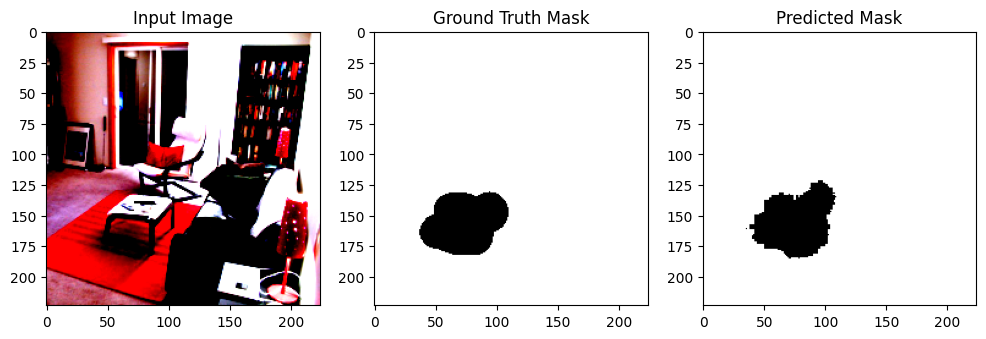

  1%|          | 1/138 [00:26<1:00:42, 26.59s/it]

tensor(0.0172)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


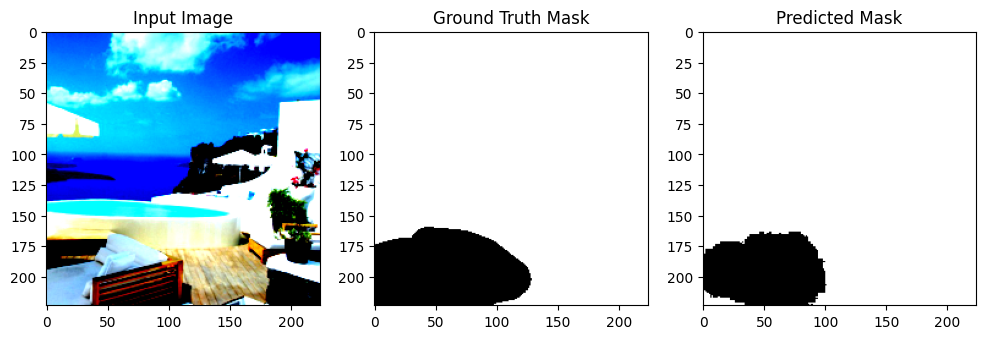

  1%|▏         | 2/138 [01:08<1:20:34, 35.55s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0190)


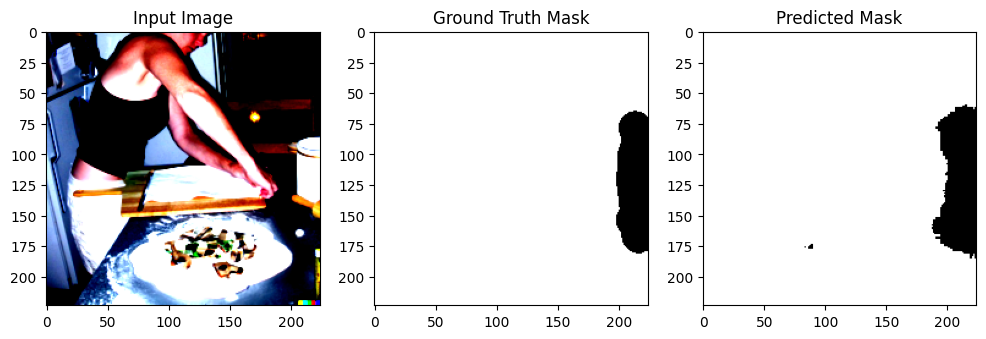

  2%|▏         | 3/138 [01:09<44:18, 19.69s/it]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0240)


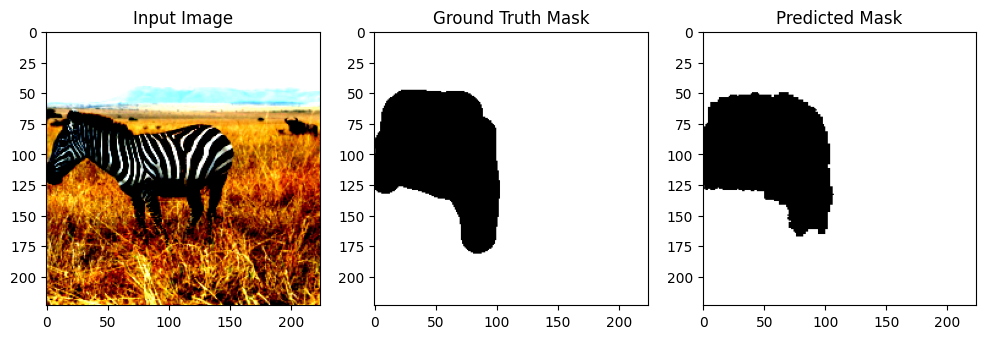

  3%|▎         | 4/138 [01:09<26:54, 12.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


tensor(0.0164)


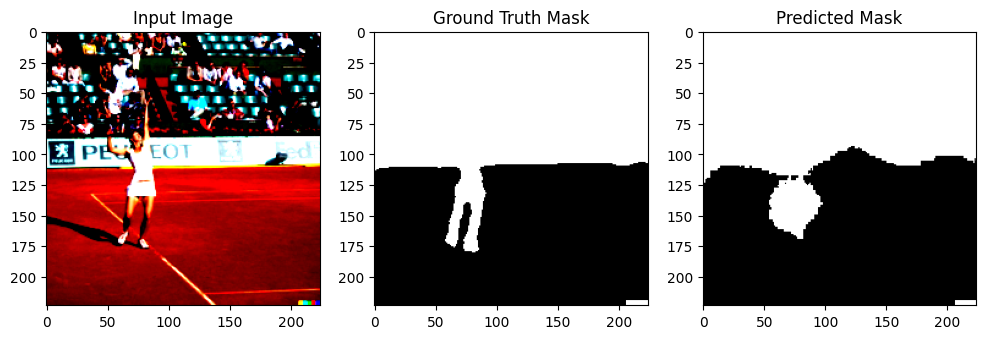

  4%|▎         | 5/138 [01:09<17:22,  7.84s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0394)


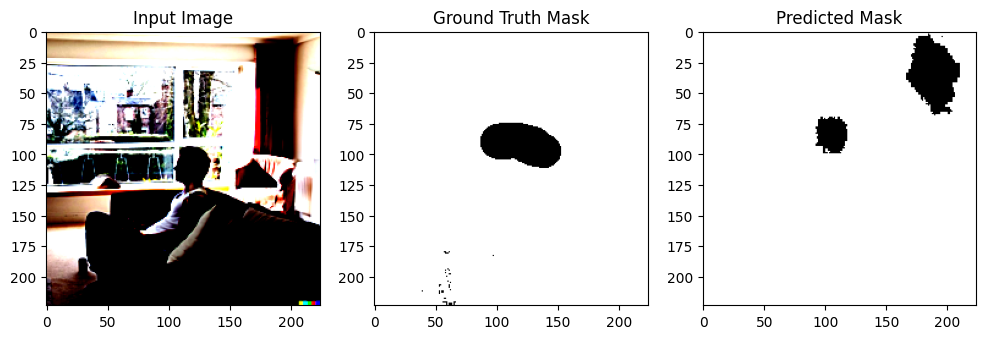

  4%|▍         | 6/138 [01:10<11:40,  5.31s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


tensor(0.0230)


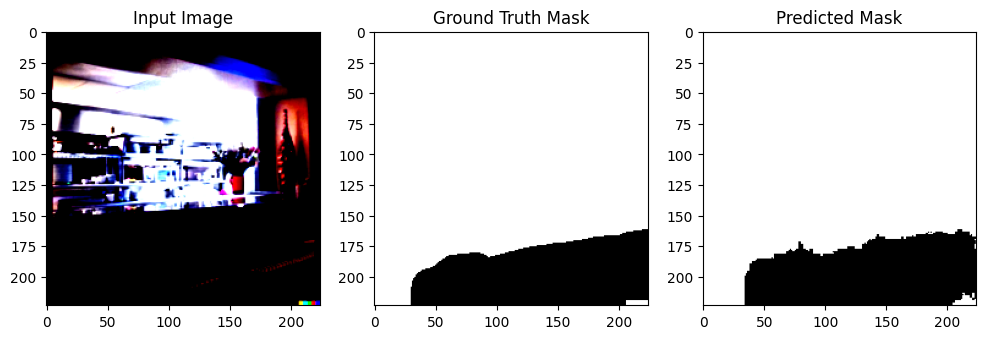

  5%|▌         | 7/138 [01:10<08:04,  3.70s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..2.64].


tensor(0.0285)


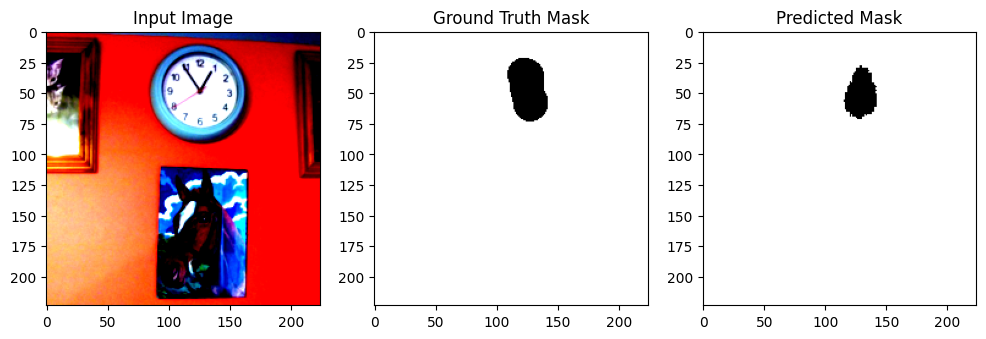

  6%|▌         | 8/138 [01:11<05:46,  2.67s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


tensor(0.0190)


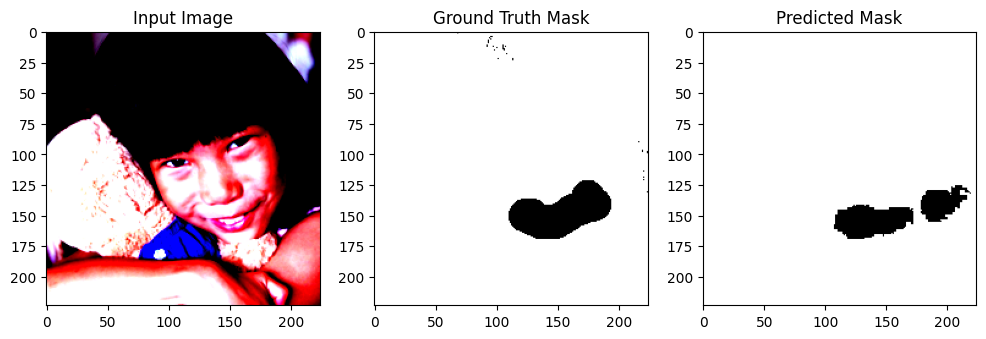

  7%|▋         | 9/138 [01:11<04:15,  1.98s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


tensor(0.0188)


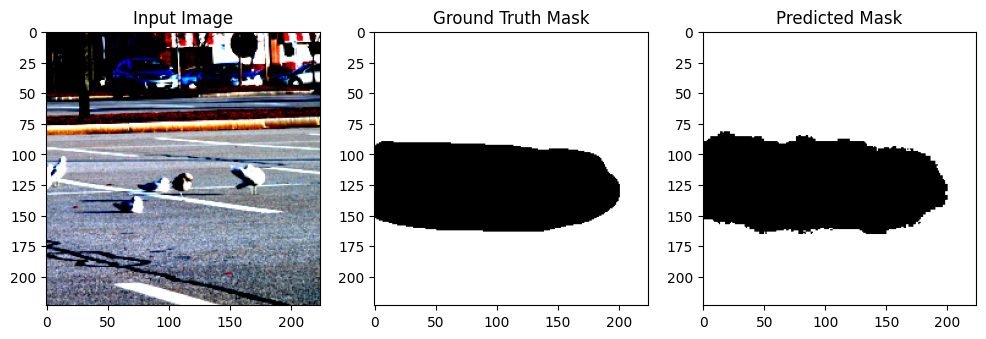

  7%|▋         | 10/138 [01:12<03:11,  1.50s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0148)


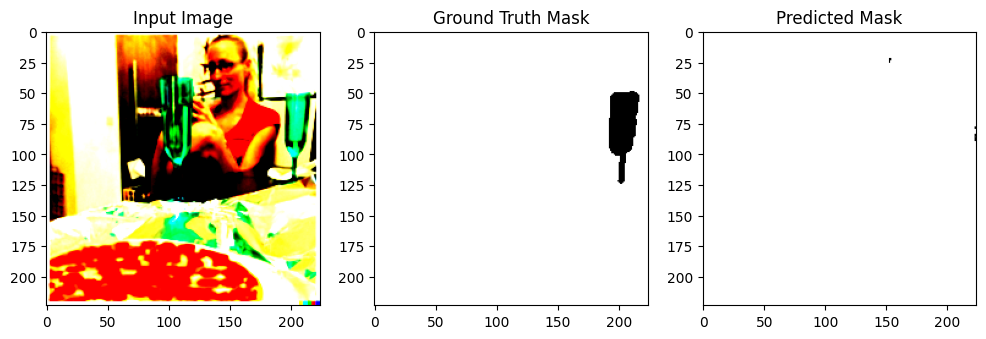

  8%|▊         | 11/138 [01:12<02:30,  1.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0131)


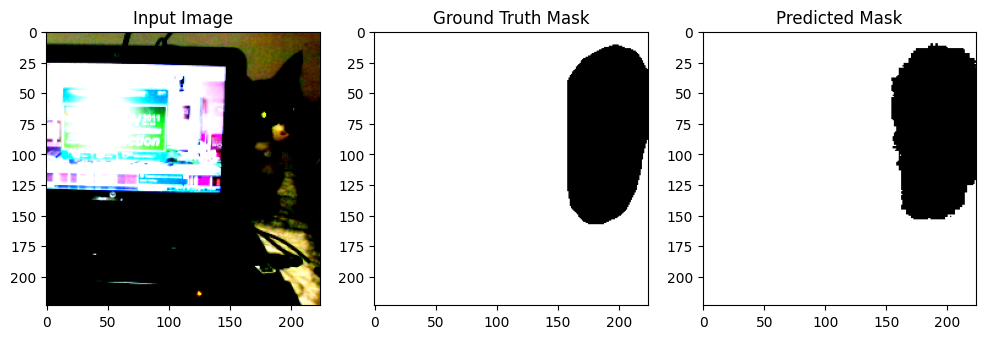

  9%|▊         | 12/138 [01:12<01:59,  1.06it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


tensor(0.0178)


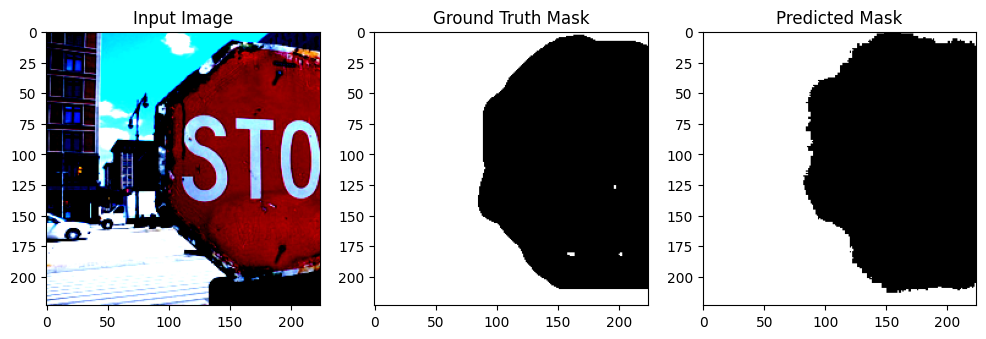

  9%|▉         | 13/138 [01:13<01:40,  1.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


tensor(0.0226)


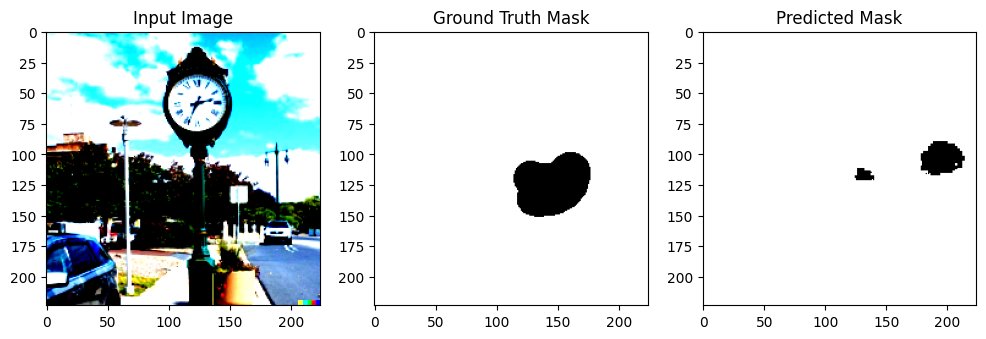

 10%|█         | 14/138 [01:14<01:44,  1.18it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.5702832].


tensor(0.0273)


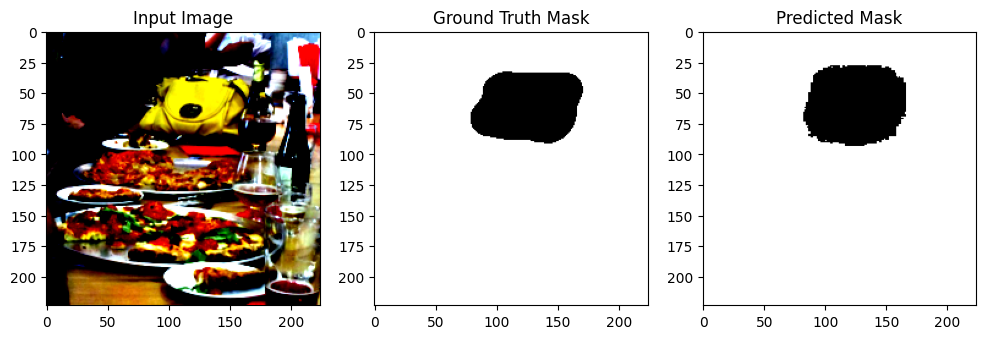

 11%|█         | 15/138 [01:14<01:31,  1.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


tensor(0.0196)


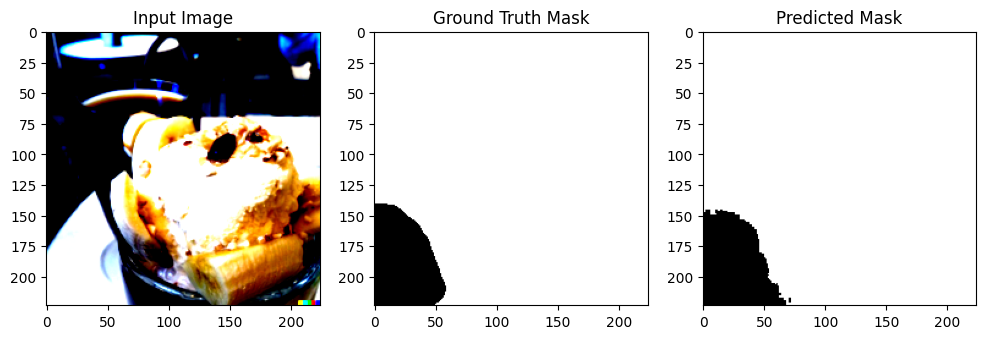

 12%|█▏        | 16/138 [01:15<01:23,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


tensor(0.0180)


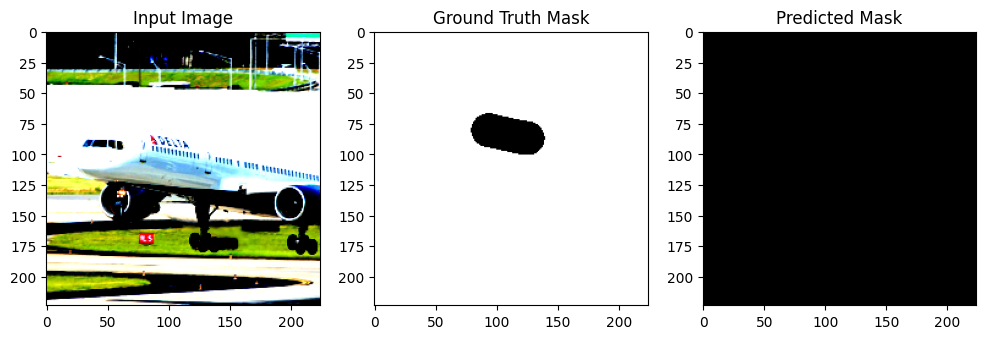

 12%|█▏        | 17/138 [01:15<01:17,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0130)


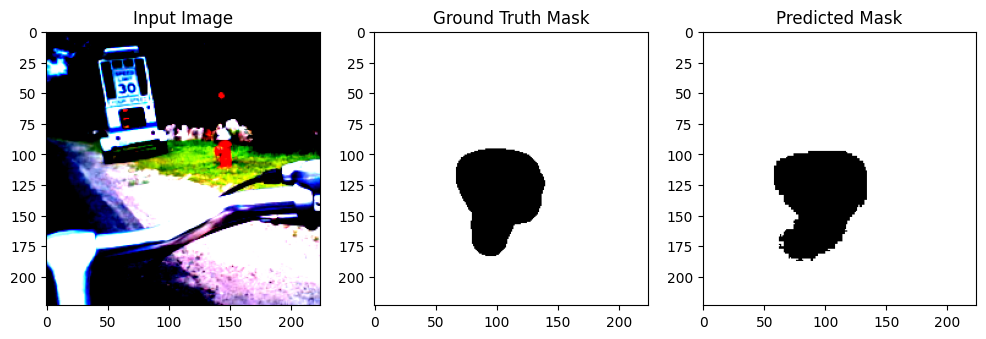

 13%|█▎        | 18/138 [01:16<01:11,  1.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0213)


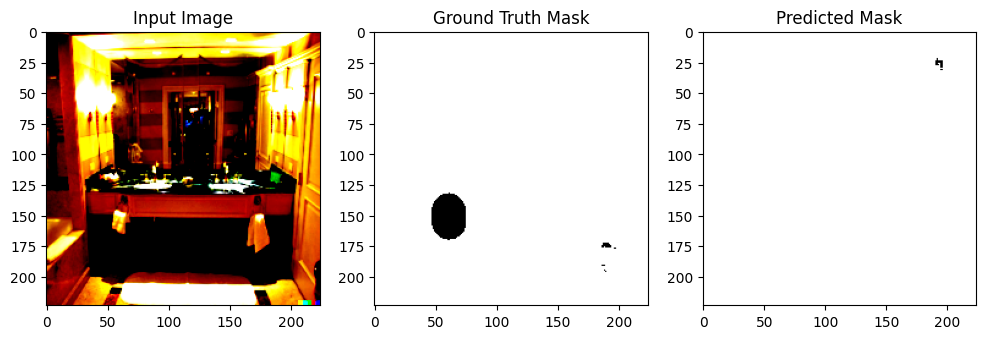

 14%|█▍        | 19/138 [01:24<05:55,  2.99s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


tensor(0.0156)


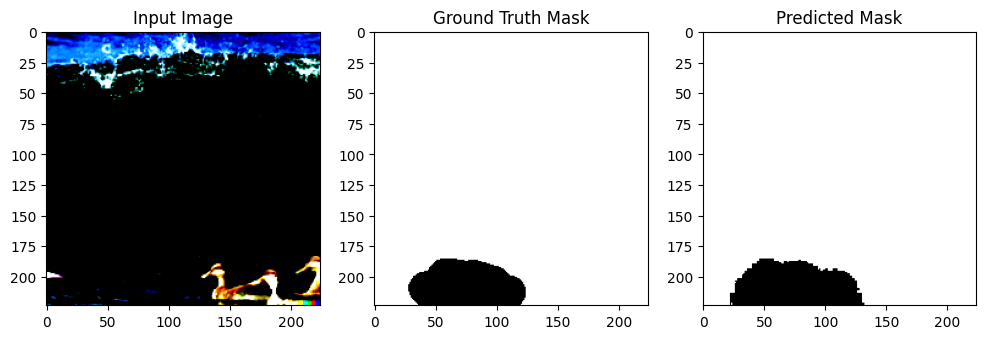

 14%|█▍        | 20/138 [01:25<04:30,  2.30s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0153)


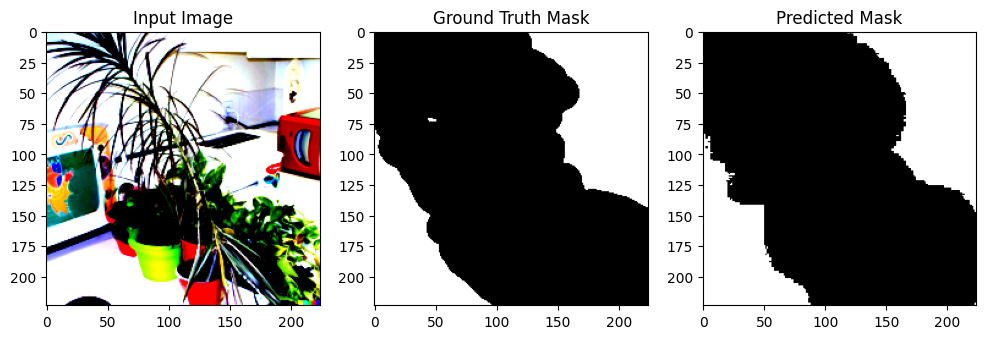

 15%|█▌        | 21/138 [01:26<03:30,  1.80s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8556864].


tensor(0.0231)


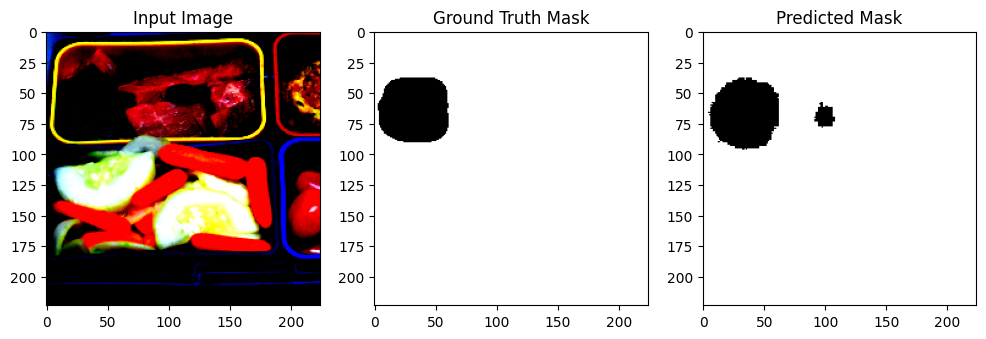

 16%|█▌        | 22/138 [01:27<02:57,  1.53s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0120)


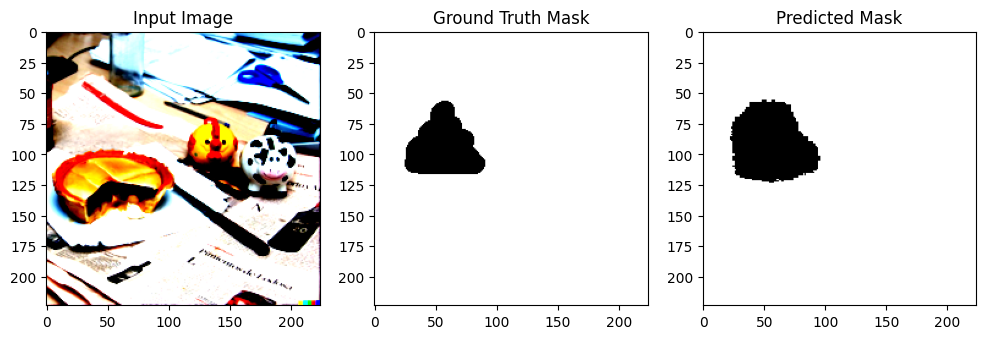

 17%|█▋        | 23/138 [01:27<02:27,  1.29s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0176)


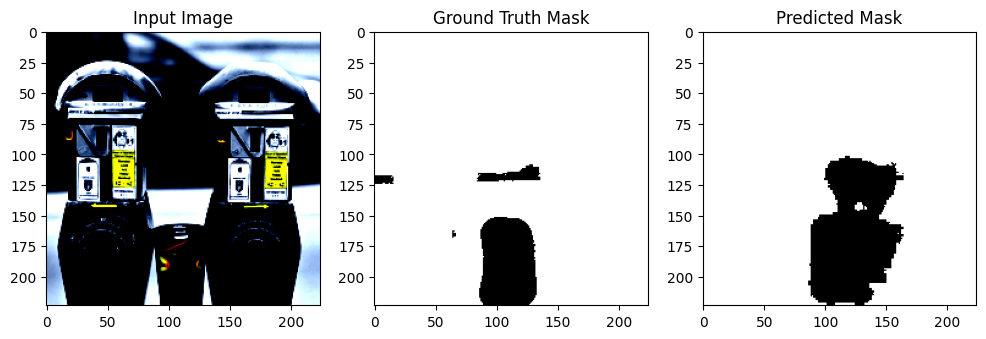

 17%|█▋        | 24/138 [01:28<02:10,  1.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0148)


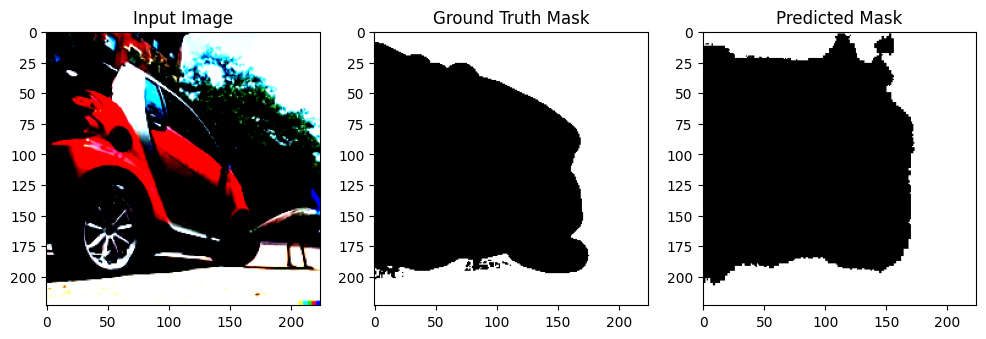

 18%|█▊        | 25/138 [01:32<03:48,  2.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


tensor(0.0220)


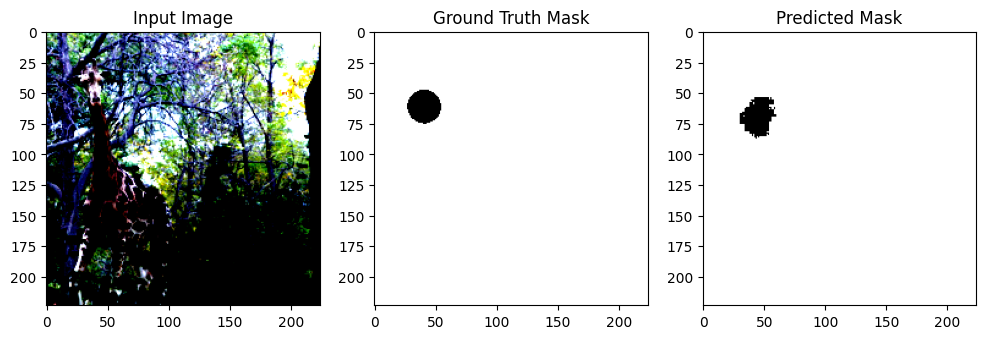

 19%|█▉        | 26/138 [01:33<03:00,  1.61s/it]

tensor(0.0162)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


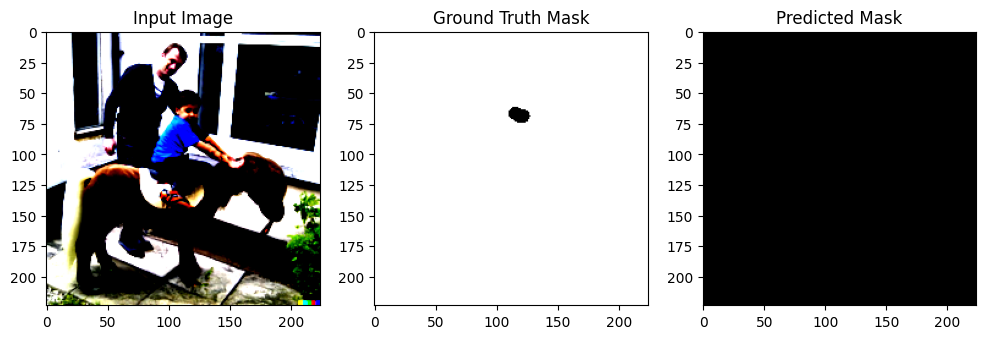

 20%|█▉        | 27/138 [01:43<07:33,  4.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


tensor(0.0198)


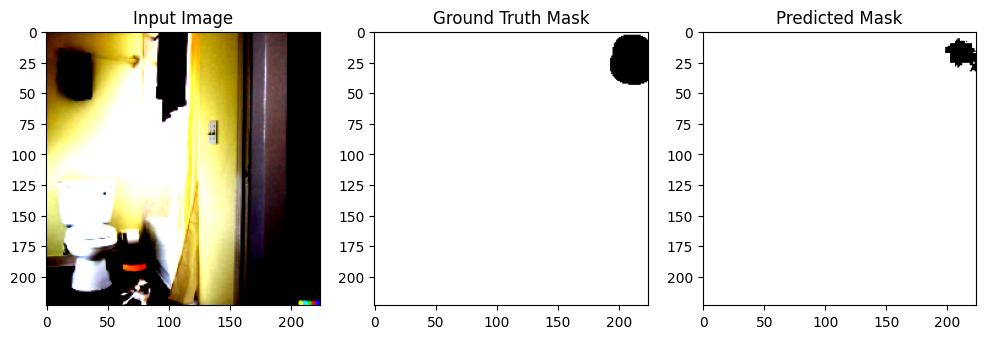

 20%|██        | 28/138 [01:43<05:33,  3.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


tensor(0.0117)


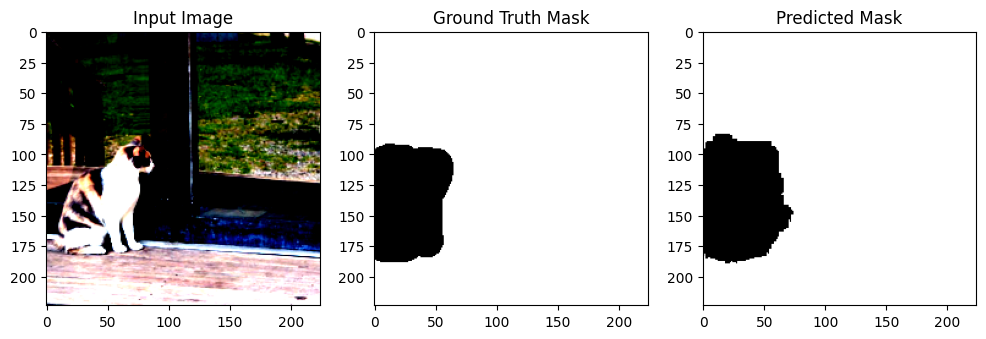

 21%|██        | 29/138 [01:44<04:11,  2.30s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].


tensor(0.0151)


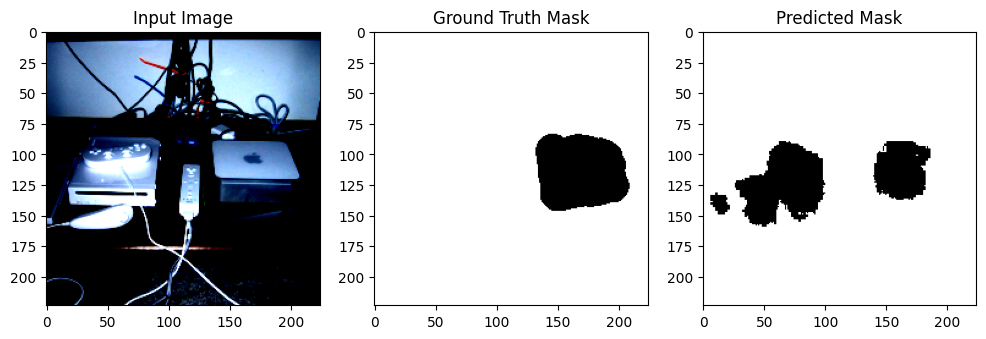

 22%|██▏       | 30/138 [01:45<03:10,  1.77s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0151)


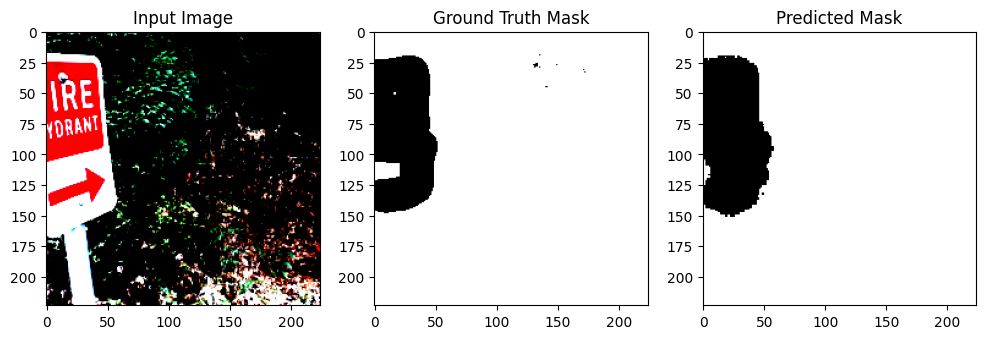

 22%|██▏       | 31/138 [01:45<02:28,  1.39s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2739873].


tensor(0.0182)


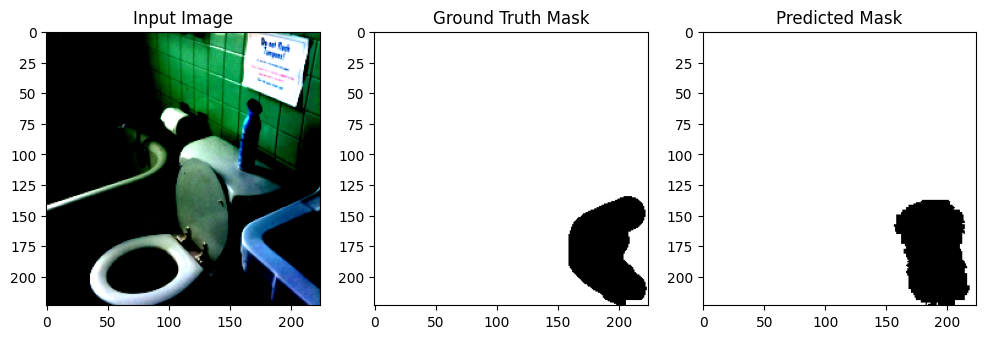

 23%|██▎       | 32/138 [01:46<02:01,  1.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


tensor(0.0194)


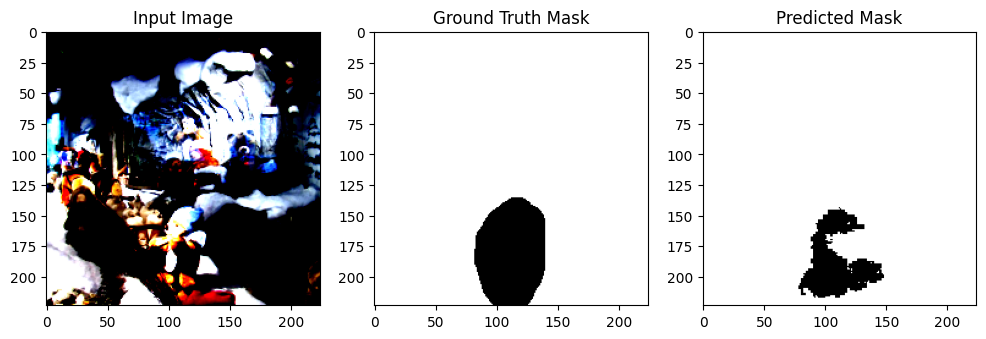

 24%|██▍       | 33/138 [01:49<03:03,  1.75s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.64].


tensor(0.0160)


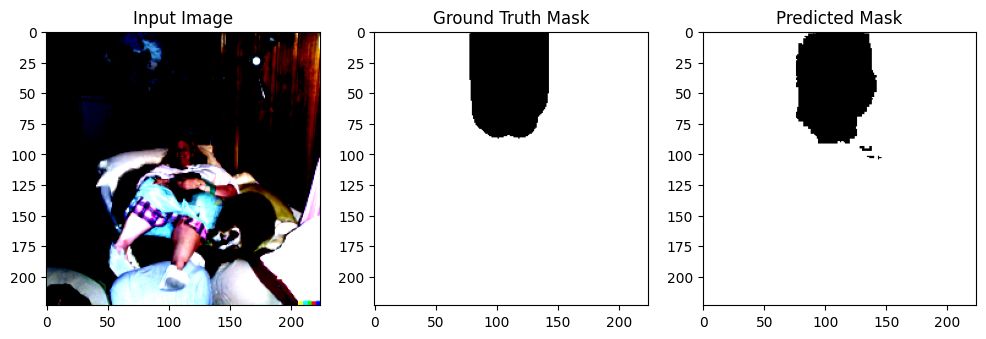

 25%|██▍       | 34/138 [01:49<02:24,  1.39s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


tensor(0.0228)


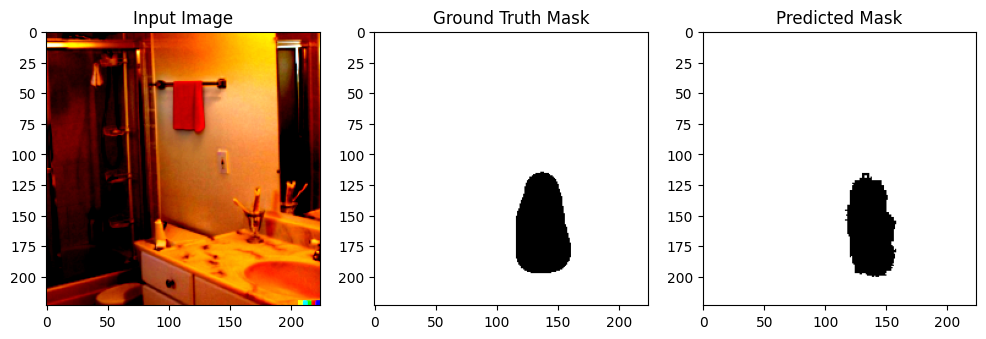

 25%|██▌       | 35/138 [01:58<06:01,  3.51s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0147)


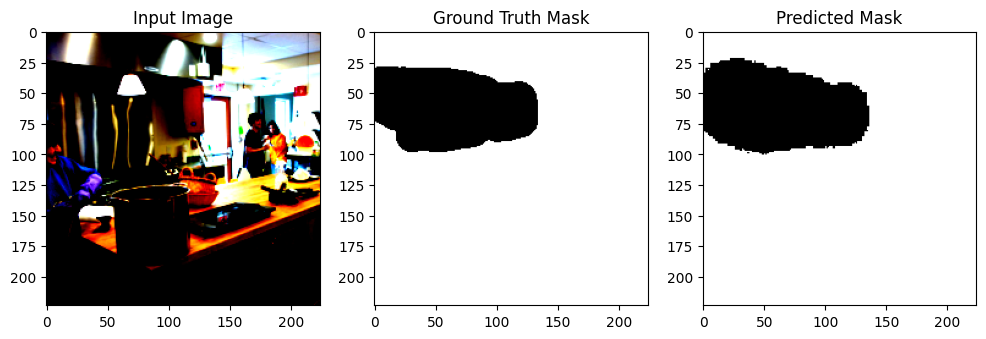

 26%|██▌       | 36/138 [01:58<04:27,  2.63s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


tensor(0.0208)


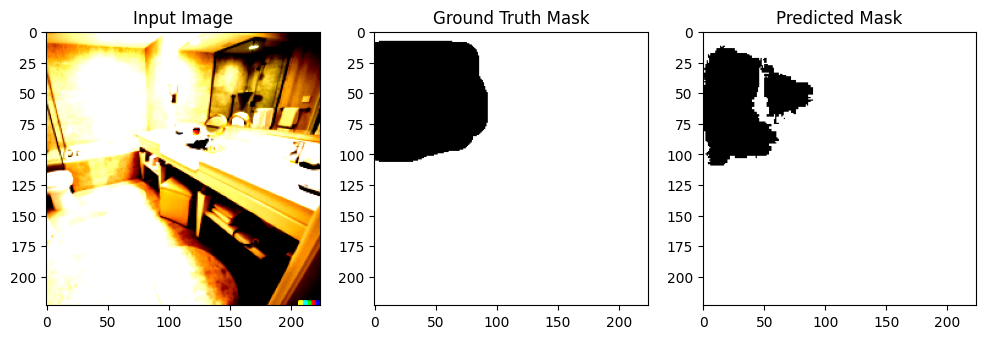

 27%|██▋       | 37/138 [02:00<03:44,  2.22s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(0.0247)


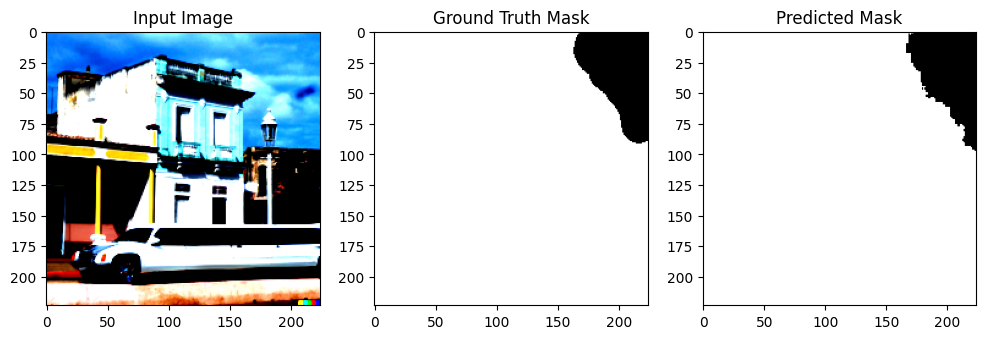

 28%|██▊       | 38/138 [02:00<02:52,  1.73s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].


tensor(0.0184)


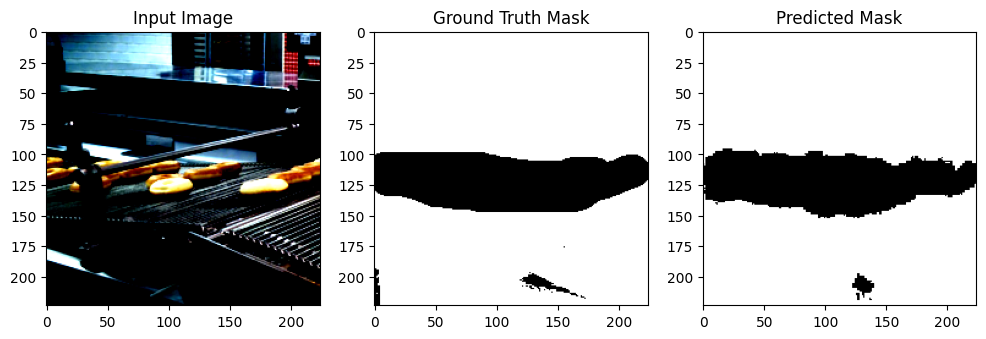

 28%|██▊       | 39/138 [02:01<02:30,  1.52s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


tensor(0.0139)


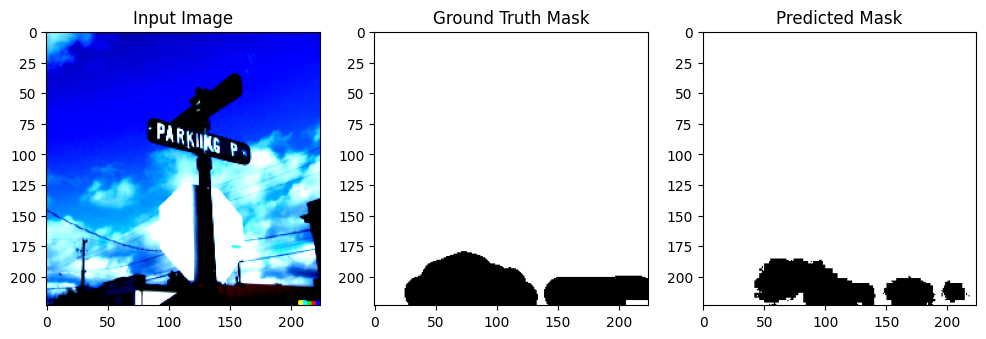

 29%|██▉       | 40/138 [02:02<02:01,  1.24s/it]

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

model = torch.load("/home/vamsi/nlp/CROSS ATTENTION BCE/crossattention_maskpredictor_200.pth")
model.eval() 

with torch.no_grad(): 
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device) 
        img = img.to(device) 
        gt_mask = gt_mask.to(device) 

        pred_mask = model(img, text_embedding)

        pred_mask = (pred_mask > 0.5).float()
        
        img = img.cpu()
        gt_mask = gt_mask.cpu()
        pred_mask = pred_mask.cpu()
        
        def dice_loss(pred, target, smooth=1):
            intersection = (pred * target).sum()
            dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
            return 1 - dice
        
        print(dice_loss(pred_mask,gt_mask))
        
        if i < 100: 
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img[0].permute(1, 2, 0))
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask[0].squeeze(), cmap="gray") 
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(pred_mask[0].squeeze(), cmap="gray") 
            axes[2].set_title("Predicted Mask")
            plt.show()
        if i==100:
            break


# bce + dice

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    # Flatten the predictions and targets to 1D for the intersection and union calculations
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return 1 - dice


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = dice_loss(pred, target)
        return bce_loss + dice

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Move model to GPU
model = model.to(device)


# Define the combined loss and optimizer
criterion = DiceBCELoss()  # Dice + BCE Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]


        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        
        # Compute combined loss (Dice + BCE)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, f"crossattention_maskpredictor_epochdice+bce{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


  0%|          | 0/138 [00:00<?, ?it/s]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  2%|▏         | 3/138 [00:13<07:52,  3.50s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  4%|▎         | 5/138 [00:13<03:52,  1.74s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  5%|▌         | 7/138 [00:13<02:16,  1.04s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  5%|▌         | 7/138 [00:24<02:16,  1.04s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  8%|▊         | 11/138 [00:26<04:08,  1.96s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


  9%|▉         | 13/138 [00:26<02:47,  1.34s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


 11%|█         | 15/138 [00:26<01:55,  1.07it/s]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


 14%|█▍        | 19/138 [00:40<03:52,  1.95s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


 15%|█▌        | 21/138 [00:40<02:41,  1.38s/it]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


 17%|█▋        | 23/138 [00:40<01:53,  1.01it/s]

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])


 17%|█▋        | 24/138 [00:50<04:01,  2.12s/it]


KeyboardInterrupt: 

# onlydice #

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    # Flatten the predictions and targets to 1D for the intersection and union calculations
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return 1 - dice


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        #self.bce = nn.BCELoss()

    def forward(self, pred, target):
        #bce_loss = self.bce(pred, target)
        dice = dice_loss(pred, target)
        return dice

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Move model to GPU
model = model.to(device)


# Define the combined loss and optimizer
criterion = DiceBCELoss()  # Dice + BCE Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]


        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        
        # Compute combined loss (Dice + BCE)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, f"crossattention_maskpredictor_epochdice{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


  5%|▌         | 7/138 [00:25<02:08,  1.02it/s]

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define IoU Loss
def iou_loss(pred, target, smooth=1e-6):
    # Flatten the predictions and targets to 1D for the intersection and union calculations
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return 1 - iou  # IoU loss is 1 - IoU

# Define the combined loss (BCE + IoU)
class CombinedLoss(nn.Module):
    def __init__(self, lambda_bce=1.0, lambda_iou=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.lambda_bce = lambda_bce
        self.lambda_iou = lambda_iou

    def forward(self, pred, target):
        # Binary Cross-Entropy loss
        bce_loss = self.bce(pred, target)
        
        # IoU loss
        iou_loss = iou_loss(pred, target)
        
        # Combine BCE and IoU loss with the scaling factors
        loss = self.lambda_bce * bce_loss + self.lambda_iou * iou_loss
        return loss

# bce+iou #

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define IoU Loss
def iou_loss(pred, target, smooth=1e-6):
    # Flatten the predictions and targets to 1D for the intersection and union calculations
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return 1 - iou  # IoU loss is 1 - IoU

# Define the combined loss (BCE + IoU)
class CombinedLoss(nn.Module):
    def __init__(self, lambda_bce=1.0, lambda_iou=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.lambda_bce = lambda_bce
        self.lambda_iou = lambda_iou

    def forward(self, pred, target):
        # Binary Cross-Entropy loss
        bce_loss = self.bce(pred, target)
        
        # IoU loss
        iou_losss = iou_loss(pred, target)
        
        # Combine BCE and IoU loss with the scaling factors
        loss = self.lambda_bce * bce_loss + self.lambda_iou * iou_losss
        return loss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Move model to GPU
model = model.to(device)


# Define the combined loss and optimizer
criterion = CombinedLoss()  # Dice + BCE Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]


        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        
        # Compute combined loss (Dice + BCE)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, f"crossattention_maskpredictor_epochioubce{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


 58%|█████▊    | 80/138 [02:20<01:41,  1.76s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define Contour Loss (Gradient-based using Sobel operator)
def contour_loss(pred, target):
    # Sobel kernels for edge detection
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(pred.device)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(pred.device)

    # Ensure the inputs have an additional channel dimension
    pred = pred.unsqueeze(1)  # Convert from [batch_size, 224, 224] to [batch_size, 1, 224, 224]
    target = target.unsqueeze(1)  # Convert from [batch_size, 224, 224] to [batch_size, 1, 224, 224]

    # Apply Sobel filters to both predicted and target masks
    grad_pred_x = F.conv2d(pred, sobel_x, padding=1)
    grad_pred_y = F.conv2d(pred, sobel_y, padding=1)
    grad_target_x = F.conv2d(target, sobel_x, padding=1)
    grad_target_y = F.conv2d(target, sobel_y, padding=1)

    # Compute gradient magnitudes
    grad_pred = torch.sqrt(grad_pred_x ** 2 + grad_pred_y ** 2)
    grad_target = torch.sqrt(grad_target_x ** 2 + grad_target_y ** 2)

    # Compute Contour loss (L1 loss between gradients)
    contour_loss = F.l1_loss(grad_pred, grad_target)
    return contour_loss


# Define the combined loss (BCE + Contour)
class BCEContourLoss(nn.Module):
    def __init__(self, lambda_bce=1.0, lambda_contour=1.0):
        super(BCEContourLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
        self.lambda_bce = lambda_bce
        self.lambda_contour = lambda_contour

    def forward(self, pred, target):
        # Compute BCE Loss
        bce_loss_value = self.bce(pred, target)
        
        # Compute Contour Loss
        contour_loss_value = contour_loss(pred.sigmoid(), target)  # Apply sigmoid to get probabilities
        
        # Combine BCE and Contour loss with scaling factors
        total_loss = self.lambda_bce * bce_loss_value + self.lambda_contour * contour_loss_value
        print(bce_loss_value,contour_loss_value)
        return total_loss


# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the combined loss and optimizer
criterion = BCEContourLoss(lambda_bce=1.0, lambda_contour=1.0)  # You can adjust lambda values
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        # Compute combined loss (BCE + Contour)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:  # Save model every 5 epochs
        torch.save(model.state_dict(), f"crossattention_maskpredictor_epoch_contour{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch [1/100], Loss: nan


100%|██████████| 138/138 [04:13<00:00,  1.84s/it]


Epoch [2/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [3/100], Loss: nan


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [4/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [5/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [6/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [7/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [8/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [9/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [10/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [11/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [12/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [13/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [14/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [15/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [16/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [17/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [18/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [19/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [20/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [21/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [22/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [23/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [24/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [25/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [26/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [27/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [28/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [29/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [30/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [31/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [32/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [33/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [34/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [35/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [36/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [37/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [38/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [39/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [40/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [41/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [42/100], Loss: nan


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [43/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [44/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [45/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [46/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [47/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [48/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [49/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [50/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [51/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [52/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [53/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [54/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [55/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [56/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [57/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [58/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [59/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [60/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [61/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [62/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [63/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [64/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [65/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [66/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [67/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [68/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [69/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [70/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [71/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [72/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [73/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [74/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [75/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [76/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [77/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [78/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [79/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [80/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [81/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [82/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [83/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [84/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [85/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [86/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [87/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [88/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [89/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [90/100], Loss: nan


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [91/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [92/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [93/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [94/100], Loss: nan


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [95/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [96/100], Loss: nan


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [97/100], Loss: nan


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [98/100], Loss: nan


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [99/100], Loss: nan


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [100/100], Loss: nan


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define Contour Loss (Gradient-based using Sobel operator)
def contour_loss(pred, target):
    # Sobel kernels for edge detection
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(pred.device)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(pred.device)

    # Ensure the inputs have an additional channel dimension
    pred = pred.unsqueeze(1)  # Convert from [batch_size, 224, 224] to [batch_size, 1, 224, 224]
    target = target.unsqueeze(1)  # Convert from [batch_size, 224, 224] to [batch_size, 1, 224, 224]

    # Apply Sobel filters to both predicted and target masks
    grad_pred_x = F.conv2d(pred, sobel_x, padding=1)
    grad_pred_y = F.conv2d(pred, sobel_y, padding=1)
    grad_target_x = F.conv2d(target, sobel_x, padding=1)
    grad_target_y = F.conv2d(target, sobel_y, padding=1)

    # Compute gradient magnitudes
    grad_pred = torch.sqrt(grad_pred_x ** 2 + grad_pred_y ** 2)
    grad_target = torch.sqrt(grad_target_x ** 2 + grad_target_y ** 2)

    # Compute Contour loss (L1 loss between gradients)
    contour_loss = F.l1_loss(grad_pred, grad_target)
    return contour_loss


# Define the combined loss (BCE + Contour)
class BCEContourLoss(nn.Module):
    def __init__(self, lambda_bce=1.0, lambda_contour=1.0):
        super(BCEContourLoss, self).__init__()
        self.bce = nn.BCELoss()  # Binary Cross-Entropy Loss with logits
        self.lambda_bce = lambda_bce
        self.lambda_contour = lambda_contour

    def forward(self, pred, target):
        # Compute BCE Loss
        bce_loss_value = self.bce(pred, target)
        
        # Compute Contour Loss
        contour_loss_value = contour_loss(pred.sigmoid(), target)  # Apply sigmoid to get probabilities
        
        # Combine BCE and Contour loss with scaling factors
        total_loss = self.lambda_bce * bce_loss_value + self.lambda_contour * contour_loss_value
        return total_loss


# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the combined loss and optimizer
criterion = BCEContourLoss(lambda_bce=1.0, lambda_contour=1.0)  # You can adjust lambda values
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        
        # Compute combined loss (BCE + Contour)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:  # Save model every 5 epochs
        torch.save(model.state_dict(), f"crossattention_maskpredictor_epoch_contour{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


100%|██████████| 138/138 [03:58<00:00,  1.73s/it]


Epoch [1/100], Loss: 0.5534


100%|██████████| 138/138 [04:01<00:00,  1.75s/it]


Epoch [2/100], Loss: 0.4895


100%|██████████| 138/138 [03:53<00:00,  1.70s/it]


Epoch [3/100], Loss: 0.4828


100%|██████████| 138/138 [03:50<00:00,  1.67s/it]


Epoch [4/100], Loss: 0.4781


 90%|████████▉ | 124/138 [03:30<00:24,  1.76s/it]../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [32,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [33,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [34,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [35,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [36,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [37,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [50,0,0], thread: [38

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/tmp/ipykernel_2226337/1656932184.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crossattention_maskpredictor_epoch_contour100.pth"))


tensor(1.0000)


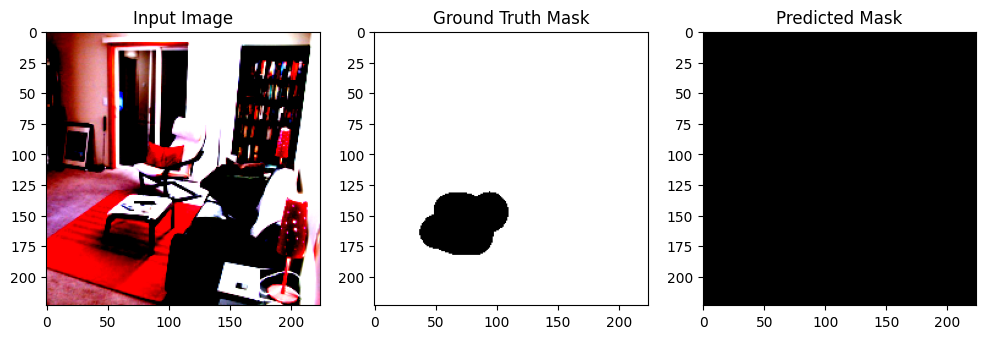

  1%|          | 1/138 [00:16<36:55, 16.17s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(1.0000)


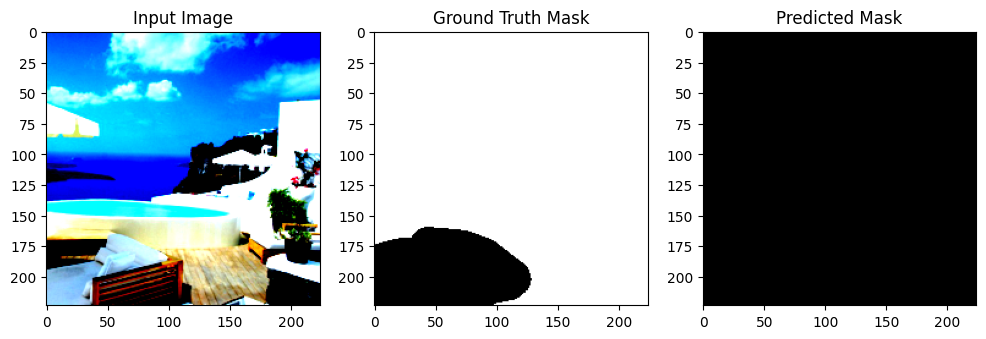

  1%|▏         | 2/138 [00:16<15:43,  6.94s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(1.0000)


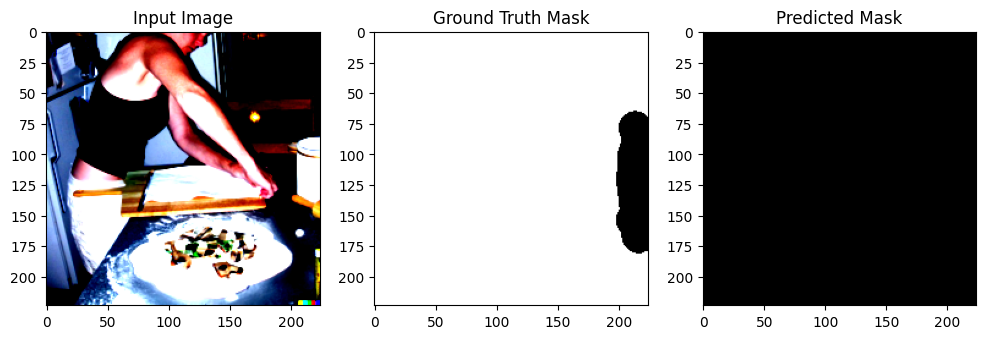

  2%|▏         | 3/138 [00:22<14:08,  6.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(1.0000)


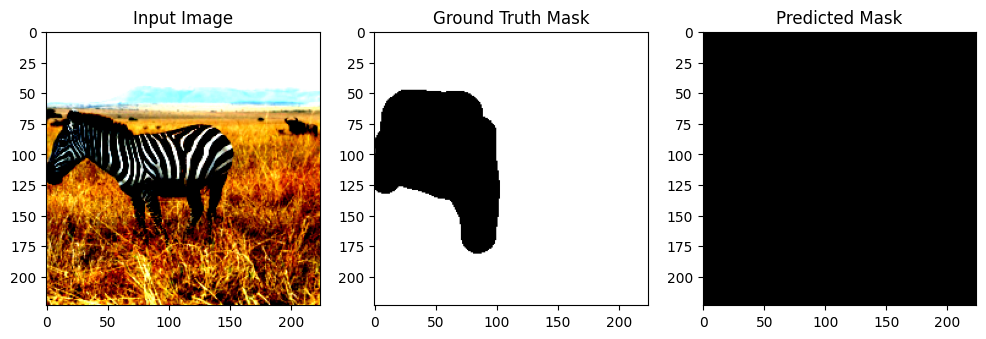

  3%|▎         | 4/138 [00:22<09:10,  4.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


tensor(1.0000)


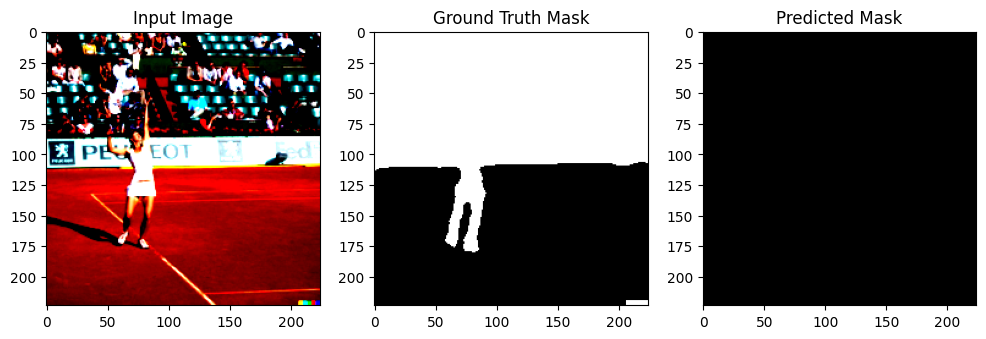

  4%|▎         | 5/138 [00:23<06:13,  2.81s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor(1.0000)


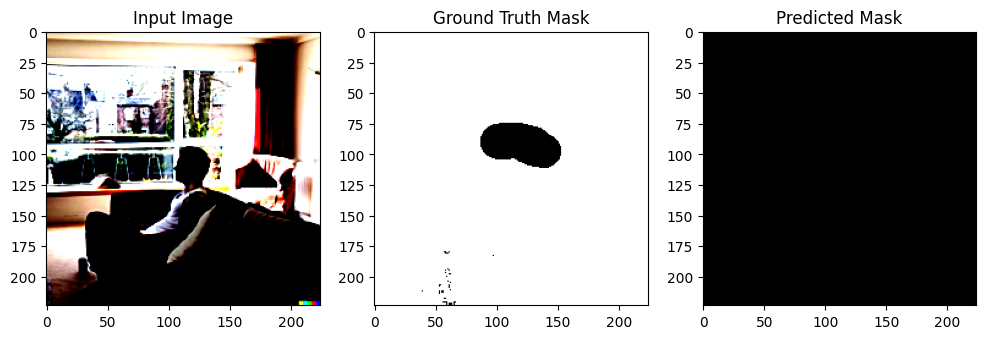

  4%|▍         | 6/138 [00:23<04:24,  2.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


tensor(1.0000)


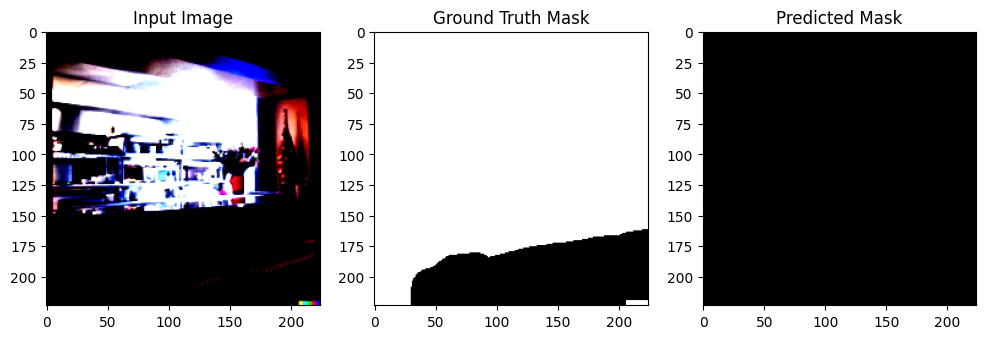

  5%|▌         | 7/138 [00:24<03:15,  1.50s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..2.64].


tensor(1.0000)


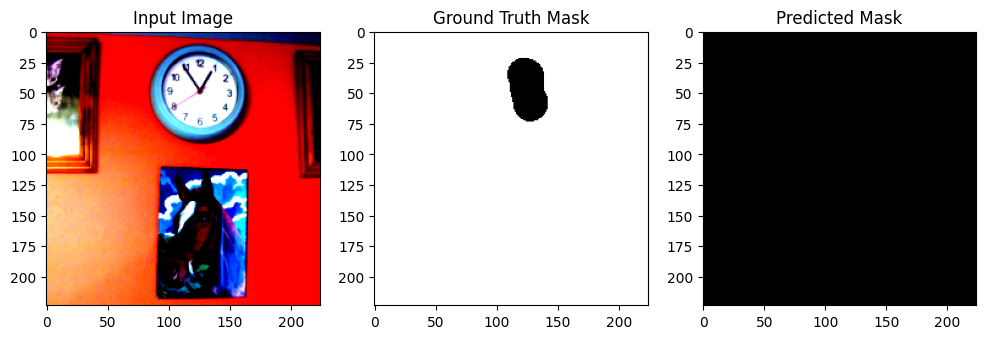

  6%|▌         | 8/138 [00:28<07:35,  3.51s/it]


KeyboardInterrupt: 

In [17]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = MaskPredictor(resnet, projection_layer).to(device)
model.load_state_dict(torch.load("crossattention_maskpredictor_epoch_contour100.pth"))
model.eval() 

with torch.no_grad(): 
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device) 
        img = img.to(device) 
        gt_mask = gt_mask.to(device) 

        pred_mask = model(img, text_embedding)
        #pred_mask = torch.sigmoid(pred_mask) 
        pred_mask = (pred_mask > 0.8).float()
        
        img = img.cpu()
        gt_mask = gt_mask.cpu()
        pred_mask = pred_mask.cpu()
        
        def dice_loss(pred, target, smooth=1):
            intersection = (pred * target).sum()
            dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
            return 1 - dice
        
        print(dice_loss(pred_mask,gt_mask))
        
        # Display a few predictions
        if i < 100:  # Display first 3 samples
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img[0].permute(1, 2, 0))  # Show original image
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(pred_mask[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[2].set_title("Predicted Mask")
            plt.show()
        # print(text_embedding)
        if i==100:
            break
